## COVID-19

### Step 2 - rework the incoming data

During the early weeks, data was reported as provinces for China and countries elsewhere. The first U.S. cases were reported by state. Everything was well contained and fairly tidy.

Since that time, the data has become a little wilder.
- In March, the U.S. data changed to county, state, e.g. from "Washington" to "King County, Washington".
- U.S. counties do not all include the term "county", e.g. Wayne, Michigan should be Wayne County, Michigan
- As passengers from various cruise ships returned home, they were being recorded with the correct country but with 'Province/State' listed as "From Diamond Princess."

This step reads in the Johns Hopkins (JH) data processed in Step 1

and then performs the following actions:
    1. Split the field "Province/State" and create three new fields:  "County"  "State"  "isSpecialLocation"
    2. Add the term "county" to U.S. counties
    3. Check known counties or provinces so that a new entry in this field can be flagged (for example, if there is another cruise ship)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import geonamescache

from unidecode import unidecode

from mpl_toolkits.basemap import Basemap

# PEP 484 type hints are easier with this
from typing import Tuple

## GLOBALS

TODO: Move global variables here once the dust has settled.

In [2]:
fname = 'most_recent_COVID-19.csv'

GLOBAL_FILL_STRING = 'not_provided'

gc = geonamescache.GeonamesCache()

countries = gc.get_countries()
us_states = gc.get_us_states()

In [3]:
# Country divisions - 1st level are all going to be called "states" for simplicity; this includes 
#         state, provinces, territories, etc.
us_states = gc.get_us_states()
stateID_list = list(us_states.keys())

australian_states_list = ['New South Wales', 'Queensland','South Australia','Tasmania','Victoria','Western Australia',\
                    'Australian Capital Territory','Jervis Bay Territory','Northern Territory',\
                    'Ashmore and Cartier Islands','Australian Antarctic Territory','Christmas Island',\
                    'Cocos (Keeling) Islands','Coral Sea Islands','Heard Island and McDonald Islands',\
                    'Norfolk Island']

canadian_states_list = ['British Columbia','Alberta','Saskatchewan','Manitoba','Ontario','Quebec','Nova Scotia',\
                   'New Brunswick','Prince Edward Island','Newfoundland and Labrador',\
                   'Yukon Territory','Northwest Territory', 'Nunavut Territory']

## FUNCTIONS

In [4]:
# https://stackoverflow.com/questions/17411940/matplotlib-scatter-plot-legend
# Handy way to build the legend
def get_legend_markers(D_label_color, marker="o", marker_kws={"linestyle":""}):
    """
    Usage: plt.legend(*legend_vars(D_taxon_color),
                      loc="lower center",
                      bbox_to_anchor=(0.5,-0.15),
                      fancybox=True, shadow=True,
                      prop={'size':15})

    Input: Dictionary object of {label:color}
    Output: Tuple of markers and labels
    """
    # Any marker you want to have in the legend must be put on the plot; this makes sure that it's on there.
    markers = [plt.Line2D([0,0],[0,0],color=color, marker=marker, **marker_kws) for color in D_label_color.values()]
    return (markers, D_label_color.keys())

## EXPLORE

In [5]:
# Read in starting data

df = pd.read_csv(fname, parse_dates=['Date'])

In [6]:
df.dtypes

Province/State            object
Country/Region            object
Lat                      float64
Long                     float64
Date              datetime64[ns]
Confirmed                  int64
Deaths                     int64
Recovered                  int64
dtype: object

In [7]:
df[['Province/State','Country/Region']] = df[['Province/State','Country/Region']].fillna(GLOBAL_FILL_STRING)

In [8]:
df.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,not_provided,Thailand,15.0000,101.0000,2020-01-22,2,0,0
1,not_provided,Japan,36.0000,138.0000,2020-01-22,2,0,0
2,not_provided,Singapore,1.2833,103.8333,2020-01-22,0,0,0
3,not_provided,Nepal,28.1667,84.2500,2020-01-22,0,0,0
4,not_provided,Malaysia,2.5000,112.5000,2020-01-22,0,0,0


In [9]:
# These are totals over all days, which means many repeated counts -- this 
# is just to make sure we have entries for various countries.
df['Country/Region'].value_counts()

United States    14326
China             1914
Canada             638
Australia          522
France             522
                 ...  
Bangladesh          58
Brazil              58
Nigeria             58
Rwanda              58
Malta               58
Name: Country/Region, Length: 155, dtype: int64

In [10]:
def handle_special_locations(name:str, verbose=False)->bool:
    '''Catch the special locations...
        print them out if they are new
        otherwise just return True so that they are flagged
    '''
    if (name == "From Diamond Princess"):
        return True
    elif (name == GLOBAL_FILL_STRING):
        return False
    else:
        if (verbose):
            print("Unrecognized location: {}".format(name))
        return False

In [11]:
def test__handle_special_locations()->bool:
    '''Unit test
       This is not an essential piece of data analysis; this is to support code development.
    '''
    b1T = handle_special_locations("From Diamond Princess")
    b2F = handle_special_locations(GLOBAL_FILL_STRING)
    b3F = handle_special_locations("That other cruise ship")
    b4F = handle_special_locations("And this cruise ship",True)
    
    if (b1T & ~(b2F | b3F | b4F)):
        print("test complete: all good")
        return True
    else:
        return False

test__handle_special_locations()


Unrecognized location: And this cruise ship
test complete: all good


True

In [12]:
def split_US_county_state(ps: str)->Tuple[str,str,bool]:
    '''Take in the string for Province/State and return 3 pieces:
        my_county : str
        my_state  : str
        my_special : bool   # For things like cruise ships
    '''
    # default values
    my_county = GLOBAL_FILL_STRING
    my_state = GLOBAL_FILL_STRING
    my_special = False
    
    if (ps == GLOBAL_FILL_STRING):
        # no Province/State info - keep the default values    
        pass
    
    elif (handle_special_locations(ps)):
        # Diamond Princess and similar
        my_county = GLOBAL_FILL_STRING
        my_state = GLOBAL_FILL_STRING
        my_special = True 
        
    else:

        uni_search = r'(?P<county>.*), (?P<state2letter>[A-Z][A-Z])($|\b)'
        # \b is a word boundary like white space      
        #print("uni_search is: .{}.".format(uni_search))

        regexp = re.compile(uni_search,flags=re.IGNORECASE)
        result = regexp.search(ps)
        #print ("   result is {}".format(result))
            
         # older data has just the state, not county, ST, so just copy over
        if (result == None):             
            stateName = ps  
            countyName = GLOBAL_FILL_STRING
        else:
            stateID = result.group('state2letter')               
            if (stateID not in stateID_list):                      # typo? or change in source data?
                print("WARNING: stateID {} not in the list of states for the United States.".format(stateID))
                stateName = us_states[stateID]['name'] 
            else:
                stateName = us_states[stateID]['name']
                                  
            # Get the county name, and make sure it includes the word "County"
            countyName = result.group('county')
            #regex_county = re.compile('county',flags=re.IGNORECASE)
            #result = regex_county.search(countyName)
            if (result == None):
                countyName = countyName + ' County'
                    
        my_state = stateName                
        my_county = countyName
    return my_county, my_state, my_special


In [13]:
def split_ProvinceState(row: pd.core.series.Series,debug=False)-> pd.core.series.Series:
    '''Split Province/State into 3 parts:  State, County, City'''
    
    ps = row['Province/State']
    if (debug):
        print("Province/State is {} which is of type {}".format(ps, type(ps)))
    
    # Rather than fill these in for every case, start with the 'generic' and over-write if they need updates
    row['State'] = GLOBAL_FILL_STRING
    row['County'] = GLOBAL_FILL_STRING
    row['isSpecialLocation'] = False   # such as cruise ships
    
    # Separate county, state
    if (row['Country/Region'] == 'United States'):                        # United States
        str1, str2, mybool = split_US_county_state(ps)
        row['County'] = str1
        row['State']  = str2 
        row['isSpecialLocation'] = mybool
        
    elif (row['Country/Region'] == 'Australia'):                          # Australia
        if (ps in australian_states_list):
            row['State'] = ps
            row['County'] = GLOBAL_FILL_STRING           
        else:    
            print("WARNING: stateID {} not in the list of states for Australia.".format(ps))
            row['isSpecialLocation'] = handle_special_locations(ps)
        
    elif (row['Country/Region'] == 'Canada'):                            # Canada
        if (ps in canadian_states_list):
            row['State'] = ps
            row['County'] = GLOBAL_FILL_STRING           
        else:    
            print("WARNING: stateID {} not in the list of states for Canada.".format(ps))
            row['isSpecialLocation'] = handle_special_locations(ps)           
            
                                                                        # TODO: France, UK, China

    else:                # many countries don't have or often don't use a state-level division
        row['State'] = GLOBAL_FILL_STRING
        row['County'] = GLOBAL_FILL_STRING
        row['isSpecialLocation'] = handle_special_locations(ps)
    
    return row

In [14]:
# df = df.apply(split_ProvinceState, axis=1)              # this worked fine when there was only one parameter
df = df.apply(lambda row: split_ProvinceState(row,True), axis=1)

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is British Columbia which is of type <class 'str'>
Province/State is New South Wales which is of type <class 'str'>
Province/State is Victoria which is of type <class 'str'>
Province/State is Queensland which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Provinc

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Qinghai which is of type <class 'str'>
Province/State is Macau which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Faroe Islands which is of type <class 'str'>
Province/State is St Martin which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Channel Islands which is of type <class 'str'>
Province/State is New Brunswick which is of type <class 'str'>
Province/State is Tibet which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Saint Barthelemy which is of type <class 'str'>
Province/State is not

Province/State is Collier, FL which is of type <class 'str'>
Province/State is Pinellas, FL which is of type <class 'str'>
Province/State is Alachua, FL which is of type <class 'str'>
Province/State is Nassau, FL which is of type <class 'str'>
Province/State is Pasco, FL which is of type <class 'str'>
Province/State is Dallas, TX which is of type <class 'str'>
Province/State is Tarrant, TX which is of type <class 'str'>
Province/State is Montgomery, TX which is of type <class 'str'>
Province/State is Middlesex, NJ which is of type <class 'str'>
Province/State is Jefferson, CO which is of type <class 'str'>
Province/State is Multnomah, OR which is of type <class 'str'>
Province/State is Polk, OR which is of type <class 'str'>
Province/State is Deschutes, OR which is of type <class 'str'>
Province/State is McHenry, IL which is of type <class 'str'>
Province/State is Lake, IL which is of type <class 'str'>
Province/State is Bucks, PA which is of type <class 'str'>
Province/State is Hanove

Province/State is From Diamond Princess which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>

Province/State is Macau which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Faroe Islands which is of type <class 'str'>
Province/State is St Martin which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Channel Islands which is of type <class 'str'>
Province/State is New Brunswick which is of type <class 'str'>
Province/State is Tibet which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Saint Barthelemy which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Gibraltar which is of type <class 'str'>
Province/State is Kitsap, WA which is of type <class 'str'>
Province/State is Sol

Province/State is Deschutes, OR which is of type <class 'str'>
Province/State is McHenry, IL which is of type <class 'str'>
Province/State is Lake, IL which is of type <class 'str'>
Province/State is Bucks, PA which is of type <class 'str'>
Province/State is Hanover, VA which is of type <class 'str'>
Province/State is Lancaster, SC which is of type <class 'str'>
Province/State is Sullivan, TN which is of type <class 'str'>
Province/State is Johnson, IN which is of type <class 'str'>
Province/State is Howard, IN which is of type <class 'str'>
Province/State is St. Joseph, IN which is of type <class 'str'>
Province/State is Knox, NE which is of type <class 'str'>
Province/State is Stark, OH which is of type <class 'str'>
Province/State is Anoka, MN which is of type <class 'str'>
Province/State is Olmsted, MN which is of type <class 'str'>
Province/State is Summit, UT which is of type <class 'str'>
Province/State is Fairfield, CT which is of type <class 'str'>
Province/State is Litchfield

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Western Australia which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Pro

Province/State is New Brunswick which is of type <class 'str'>
Province/State is Tibet which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Saint Barthelemy which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Gibraltar which is of type <class 'str'>
Province/State is Kitsap, WA which is of type <class 'str'>
Province/State is Solano, CA which is of type <class 'str'>
Province/State is Santa Cruz, CA which is of type <class 'str'>
Province/State is Napa, CA which is of type <class 'str'>
Province/State is Ventura, CA which is of type <class 'str'>
Province/State is Worcester, MA which is of type <class 'str'>
Province/State is Gwinnett, GA which is of type <class 'str'>
Province/State is DeKalb, GA which is of type <class 'str'>
Province/State is Flo

Province/State is Fulton County, GA which is of type <class 'str'>
Province/State is Washington County, OR which is of type <class 'str'>
Province/State is Snohomish County, WA which is of type <class 'str'>
Province/State is Humboldt County, CA which is of type <class 'str'>
Province/State is Sacramento County, CA which is of type <class 'str'>
Province/State is San Diego County, CA which is of type <class 'str'>
Province/State is San Benito, CA which is of type <class 'str'>
Province/State is Los Angeles, CA which is of type <class 'str'>
Province/State is King County, WA which is of type <class 'str'>
Province/State is Cook County, IL which is of type <class 'str'>
Province/State is Skagit, WA which is of type <class 'str'>
Province/State is Thurston, WA which is of type <class 'str'>
Province/State is Island, WA which is of type <class 'str'>
Province/State is Whatcom, WA which is of type <class 'str'>
Province/State is Marin, CA which is of type <class 'str'>
Province/State is Cal

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Western Australia which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Pro

Province/State is Napa, CA which is of type <class 'str'>
Province/State is Ventura, CA which is of type <class 'str'>
Province/State is Worcester, MA which is of type <class 'str'>
Province/State is Gwinnett, GA which is of type <class 'str'>
Province/State is DeKalb, GA which is of type <class 'str'>
Province/State is Floyd, GA which is of type <class 'str'>
Province/State is Fayette, GA which is of type <class 'str'>
Province/State is Gregg, TX which is of type <class 'str'>
Province/State is Monmouth, NJ which is of type <class 'str'>
Province/State is Burlington, NJ which is of type <class 'str'>
Province/State is Camden, NJ which is of type <class 'str'>
Province/State is Passaic, NJ which is of type <class 'str'>
Province/State is Union, NJ which is of type <class 'str'>
Province/State is Eagle, CO which is of type <class 'str'>
Province/State is Larimer, CO which is of type <class 'str'>
Province/State is Arapahoe, CO which is of type <class 'str'>
Province/State is Gunnison, C

Province/State is Collier, FL which is of type <class 'str'>
Province/State is Pinellas, FL which is of type <class 'str'>
Province/State is Alachua, FL which is of type <class 'str'>
Province/State is Nassau, FL which is of type <class 'str'>
Province/State is Pasco, FL which is of type <class 'str'>
Province/State is Dallas, TX which is of type <class 'str'>
Province/State is Tarrant, TX which is of type <class 'str'>
Province/State is Montgomery, TX which is of type <class 'str'>
Province/State is Middlesex, NJ which is of type <class 'str'>
Province/State is Jefferson, CO which is of type <class 'str'>
Province/State is Multnomah, OR which is of type <class 'str'>
Province/State is Polk, OR which is of type <class 'str'>
Province/State is Deschutes, OR which is of type <class 'str'>
Province/State is McHenry, IL which is of type <class 'str'>
Province/State is Lake, IL which is of type <class 'str'>
Province/State is Bucks, PA which is of type <class 'str'>
Province/State is Hanove

Province/State is Western Australia which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Tasmania which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Provinc

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Qinghai which is of type <class 'str'>
Province/State is Macau which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Faroe Islands which is of type <class 'str'>
Province/State is St Martin which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Channel Islands which is of type <class 'str'>
Province/State is New Brunswick which is of type <class 'str'>
Province/State is Tibet which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Saint Barthelemy which is of type <class 'str'>
Province/State is not

Province/State is Summit County, CO which is of type <class 'str'>
Province/State is Bergen County, NJ which is of type <class 'str'>
Province/State is Harris County, TX which is of type <class 'str'>
Province/State is San Francisco County, CA which is of type <class 'str'>
Province/State is Contra Costa County, CA which is of type <class 'str'>
Province/State is Orange County, CA which is of type <class 'str'>
Province/State is Norfolk County, MA which is of type <class 'str'>
Province/State is Maricopa County, AZ which is of type <class 'str'>
Province/State is Wake County, NC which is of type <class 'str'>
Province/State is Westchester County, NY which is of type <class 'str'>
Province/State is Grafton County, NH which is of type <class 'str'>
Province/State is Hillsborough, FL which is of type <class 'str'>
Province/State is Placer County, CA which is of type <class 'str'>
Province/State is San Mateo, CA which is of type <class 'str'>
Province/State is Sonoma County, CA which is of

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province

Province/State is Faroe Islands which is of type <class 'str'>
Province/State is St Martin which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Channel Islands which is of type <class 'str'>
Province/State is New Brunswick which is of type <class 'str'>
Province/State is Tibet which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Saint Barthelemy which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Gibraltar which is of type <class 'str'>
Province/State is Kitsap, WA which is of type <class 'str'>
Province/State is Solano, CA which is of type <class 'str'>
Province/State is Santa Cruz, CA which is of type <class 'str'>
Province/State is Napa, CA which is of type <class 'str'>
Province/State is 

Province/State is Fulton County, GA which is of type <class 'str'>
Province/State is Washington County, OR which is of type <class 'str'>
Province/State is Snohomish County, WA which is of type <class 'str'>
Province/State is Humboldt County, CA which is of type <class 'str'>
Province/State is Sacramento County, CA which is of type <class 'str'>
Province/State is San Diego County, CA which is of type <class 'str'>
Province/State is San Benito, CA which is of type <class 'str'>
Province/State is Los Angeles, CA which is of type <class 'str'>
Province/State is King County, WA which is of type <class 'str'>
Province/State is Cook County, IL which is of type <class 'str'>
Province/State is Skagit, WA which is of type <class 'str'>
Province/State is Thurston, WA which is of type <class 'str'>
Province/State is Island, WA which is of type <class 'str'>
Province/State is Whatcom, WA which is of type <class 'str'>
Province/State is Marin, CA which is of type <class 'str'>
Province/State is Cal

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Western Australia which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Pro

Province/State is New Brunswick which is of type <class 'str'>
Province/State is Tibet which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Saint Barthelemy which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Gibraltar which is of type <class 'str'>
Province/State is Kitsap, WA which is of type <class 'str'>
Province/State is Solano, CA which is of type <class 'str'>
Province/State is Santa Cruz, CA which is of type <class 'str'>
Province/State is Napa, CA which is of type <class 'str'>
Province/State is Ventura, CA which is of type <class 'str'>
Province/State is Worcester, MA which is of type <class 'str'>
Province/State is Gwinnett, GA which is of type <class 'str'>
Province/State is DeKalb, GA which is of type <class 'str'>
Province/State is Flo

Province/State is Grafton County, NH which is of type <class 'str'>
Province/State is Hillsborough, FL which is of type <class 'str'>
Province/State is Placer County, CA which is of type <class 'str'>
Province/State is San Mateo, CA which is of type <class 'str'>
Province/State is Sonoma County, CA which is of type <class 'str'>
Province/State is Umatilla, OR which is of type <class 'str'>
Province/State is Fulton County, GA which is of type <class 'str'>
Province/State is Washington County, OR which is of type <class 'str'>
Province/State is Snohomish County, WA which is of type <class 'str'>
Province/State is Humboldt County, CA which is of type <class 'str'>
Province/State is Sacramento County, CA which is of type <class 'str'>
Province/State is San Diego County, CA which is of type <class 'str'>
Province/State is San Benito, CA which is of type <class 'str'>
Province/State is Los Angeles, CA which is of type <class 'str'>
Province/State is King County, WA which is of type <class 's

Province/State is British Columbia which is of type <class 'str'>
Province/State is New South Wales which is of type <class 'str'>
Province/State is Victoria which is of type <class 'str'>
Province/State is Queensland which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is South Australia which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Prov

Province/State is Guizhou which is of type <class 'str'>
Province/State is Tianjin which is of type <class 'str'>
Province/State is Shanxi which is of type <class 'str'>
Province/State is Gansu which is of type <class 'str'>
Province/State is Hong Kong which is of type <class 'str'>
Province/State is Liaoning which is of type <class 'str'>
Province/State is Jilin which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Xinjiang which is of type <class 'str'>
Province/State is Inner Mongolia which is of type <class 'str'>
Province/State is Ningxia which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Qinghai which is of type <class 'str'>
Province/State is Macau which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Pr

Province/State is Grant County, WA which is of type <class 'str'>
Province/State is Santa Rosa County, FL which is of type <class 'str'>
Province/State is Williamson County, TN which is of type <class 'str'>
Province/State is New York County, NY which is of type <class 'str'>
Province/State is Montgomery County, MD which is of type <class 'str'>
Province/State is Suffolk County, MA which is of type <class 'str'>
Province/State is Denver County, CO which is of type <class 'str'>
Province/State is Summit County, CO which is of type <class 'str'>
Province/State is Bergen County, NJ which is of type <class 'str'>
Province/State is Harris County, TX which is of type <class 'str'>
Province/State is San Francisco County, CA which is of type <class 'str'>
Province/State is Contra Costa County, CA which is of type <class 'str'>
Province/State is Orange County, CA which is of type <class 'str'>
Province/State is Norfolk County, MA which is of type <class 'str'>
Province/State is Maricopa County,

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Virgin Islands which is of type <class 'str'>
Province/State is Cayman Islands which is of type <class 'str'>
Province/State is Reunion which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Aruba which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Montserrat which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Greenland which is of type <class 'str'>
Province/State is New

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Kansas which is of type <class 'str'>
Province/State is Louisiana which is of type <class 'str'>
Province/State is Missouri which is of type <class 'str'>
Province/State is Vermont which is of type <class 'str'>
Province/State is Alaska which is of type <class 'str'>
Province/State is Arkansas which is of type <class 'str'>
Province/State is Delaware which is of type <class 'str'>
Province/State is Idaho which is of type <class 'str'>
Province/State is Maine which is of type <class 'str'>
Province/State is Michigan which is of type <class 'str'>
Province/State is Mississippi which is of type <class 'str'>
Province/State is Montana which is of type <class 'str'>
Province/State is New Mexico which is of type <class 'str'>
Prov

Province/State is Manatee County, FL which is of type <class 'str'>
Province/State is Marion County, OR which is of type <class 'str'>
Province/State is Okaloosa County, FL which is of type <class 'str'>
Province/State is Polk County, GA which is of type <class 'str'>
Province/State is Riverside County, CA which is of type <class 'str'>
Province/State is Shelby County, TN which is of type <class 'str'>
Province/State is St. Louis County, MO which is of type <class 'str'>
Province/State is Suffolk County, NY which is of type <class 'str'>
Province/State is Ulster County, NY which is of type <class 'str'>
Province/State is Volusia County, FL which is of type <class 'str'>
Province/State is Fairfax County, VA which is of type <class 'str'>
Province/State is Rockingham County, NH which is of type <class 'str'>
Province/State is Washington, D.C. which is of type <class 'str'>
Province/State is Montgomery County, PA which is of type <class 'str'>
Province/State is Alameda County, CA which is

Province/State is Bernalillo, NM which is of type <class 'str'>
Province/State is Oakland, MI which is of type <class 'str'>
Province/State is Wayne, MI which is of type <class 'str'>
Province/State is New Castle, DE which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Australian Capital Territory which is of type <class 'str'>
Province/State is United Kingdom which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is French Polynesia which is of type <class 'str'>
Province/State is Manitoba which is of type <class 'str'>
Province/State is Saskatchewan which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Grand Princess which is of type <c

Province/State is not_provided which is of type <class 'str'>
Province/State is Ontario which is of type <class 'str'>
Province/State is Alberta which is of type <class 'str'>
Province/State is Quebec which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Washington which is of type <class 'str'>
Province/State is New York which is of type <class 'str'>
Province/State is California which is of type <class 'str'>
Province/State is Massachusetts which is of type <class 'str'>
Province/State is Diamond Princess which is of type <class 'str'>
Province/State is Grand Princess which is of type <class 'str'>
Province/State is Georgia which is of type <class 'str'>
Province/State is Colorado which is of type <class 'str'>
Province/State is Florida which is of type <class 'str'>
Province/State is New Jersey which is o

Province/State is Norfolk, VA which is of type <class 'str'>
Province/State is Arlington, VA which is of type <class 'str'>
Province/State is Spotsylvania, VA which is of type <class 'str'>
Province/State is Loudoun, VA which is of type <class 'str'>
Province/State is Prince George's, MD which is of type <class 'str'>
Province/State is Pottawattamie, IA which is of type <class 'str'>
Province/State is Camden, NC which is of type <class 'str'>
Province/State is Pima, AZ which is of type <class 'str'>
Province/State is Noble, IN which is of type <class 'str'>
Province/State is Adams, IN which is of type <class 'str'>
Province/State is Boone, IN which is of type <class 'str'>
Province/State is Dane, WI which is of type <class 'str'>
Province/State is Pierce, WI which is of type <class 'str'>
Province/State is Cuyahoga, OH which is of type <class 'str'>
Province/State is Weber, UT which is of type <class 'str'>
Province/State is Bennington County, VT which is of type <class 'str'>
Province

Province/State is Hanover, VA which is of type <class 'str'>
Province/State is Lancaster, SC which is of type <class 'str'>
Province/State is Sullivan, TN which is of type <class 'str'>
Province/State is Johnson, IN which is of type <class 'str'>
Province/State is Howard, IN which is of type <class 'str'>
Province/State is St. Joseph, IN which is of type <class 'str'>
Province/State is Knox, NE which is of type <class 'str'>
Province/State is Stark, OH which is of type <class 'str'>
Province/State is Anoka, MN which is of type <class 'str'>
Province/State is Olmsted, MN which is of type <class 'str'>
Province/State is Summit, UT which is of type <class 'str'>
Province/State is Fairfield, CT which is of type <class 'str'>
Province/State is Litchfield, CT which is of type <class 'str'>
Province/State is Orleans, LA which is of type <class 'str'>
Province/State is Pennington, SD which is of type <class 'str'>
Province/State is Beadle, SD which is of type <class 'str'>
Province/State is Ch

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Ontario which is of type <class 'str'>
Province/Stat

Province/State is Monmouth, NJ which is of type <class 'str'>
Province/State is Burlington, NJ which is of type <class 'str'>
Province/State is Camden, NJ which is of type <class 'str'>
Province/State is Passaic, NJ which is of type <class 'str'>
Province/State is Union, NJ which is of type <class 'str'>
Province/State is Eagle, CO which is of type <class 'str'>
Province/State is Larimer, CO which is of type <class 'str'>
Province/State is Arapahoe, CO which is of type <class 'str'>
Province/State is Gunnison, CO which is of type <class 'str'>
Province/State is Kane, IL which is of type <class 'str'>
Province/State is Monroe, PA which is of type <class 'str'>
Province/State is Philadelphia, PA which is of type <class 'str'>
Province/State is Norfolk, VA which is of type <class 'str'>
Province/State is Arlington, VA which is of type <class 'str'>
Province/State is Spotsylvania, VA which is of type <class 'str'>
Province/State is Loudoun, VA which is of type <class 'str'>
Province/State 

Province/State is San Benito, CA which is of type <class 'str'>
Province/State is Los Angeles, CA which is of type <class 'str'>
Province/State is King County, WA which is of type <class 'str'>
Province/State is Cook County, IL which is of type <class 'str'>
Province/State is Skagit, WA which is of type <class 'str'>
Province/State is Thurston, WA which is of type <class 'str'>
Province/State is Island, WA which is of type <class 'str'>
Province/State is Whatcom, WA which is of type <class 'str'>
Province/State is Marin, CA which is of type <class 'str'>
Province/State is Calaveras, CA which is of type <class 'str'>
Province/State is Stanislaus, CA which is of type <class 'str'>
Province/State is San Joaquin, CA which is of type <class 'str'>
Province/State is Essex, MA which is of type <class 'str'>
Province/State is Charlton, GA which is of type <class 'str'>
Province/State is Collier, FL which is of type <class 'str'>
Province/State is Pinellas, FL which is of type <class 'str'>
Pro

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is From Diamond Princess which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>

Province/State is Chongqing which is of type <class 'str'>
Province/State is Sichuan which is of type <class 'str'>
Province/State is Heilongjiang which is of type <class 'str'>
Province/State is Denmark which is of type <class 'str'>
Province/State is Beijing which is of type <class 'str'>
Province/State is Shanghai which is of type <class 'str'>
Province/State is Hebei which is of type <class 'str'>
Province/State is Fujian which is of type <class 'str'>
Province/State is Guangxi which is of type <class 'str'>
Province/State is Shaanxi which is of type <class 'str'>
Province/State is Yunnan which is of type <class 'str'>
Province/State is Hainan which is of type <class 'str'>
Province/State is Guizhou which is of type <class 'str'>
Province/State is Tianjin which is of type <class 'str'>
Province/State is Shanxi which is of type <class 'str'>
Province/State is Gansu which is of type <class 'str'>
Province/State is Hong Kong which is of type <class 'str'>
Province/State is Liaoning wh

Province/State is Pierce County, WA which is of type <class 'str'>
Province/State is Tulsa County, OK which is of type <class 'str'>
Province/State is Douglas County, CO which is of type <class 'str'>
Province/State is Providence County, RI which is of type <class 'str'>
Province/State is Chatham County, NC which is of type <class 'str'>
Province/State is Delaware County, PA which is of type <class 'str'>
Province/State is Douglas County, NE which is of type <class 'str'>
Province/State is Fayette County, KY which is of type <class 'str'>
Province/State is Marion County, IN which is of type <class 'str'>
Province/State is Middlesex County, MA which is of type <class 'str'>
Province/State is Nassau County, NY which is of type <class 'str'>
Province/State is Ramsey County, MN which is of type <class 'str'>
Province/State is Washoe County, NV which is of type <class 'str'>
Province/State is Wayne County, PA which is of type <class 'str'>
Province/State is Yolo County, CA which is of type 

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is French Guiana which is of type <class 'str'>
Province/State is Guam which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Newfoundland and Labrador which is of type <class 'str'>
Province/State is Prince Edward Island which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Mayotte which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Netherlands which is of type <class 'str'>
Province/State is Nova Scotia which is of type <class 'str'>
P

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Washington which is of type <class 'str'>
Province/State is New York which is of type <class 'str'>
Province/State is California which is of type <class 'str'>
Province/State is Massachusetts which is of type <class 'str'>
Province/State is Diamond Princess which is of type <class 'str'>
Province/State is Grand Princess which is of type <class 'str'>
Province/State is Georgia which is of type <class 'str'>
Province/State is Colorado which is of type <class 'str'>
Province/State is Florida which is of type <class 'str'>
Province/State is New Jersey which is of type <class 'str'>
Province/State is Oregon which is of type <class 'str'>
Province/State is Texas which is of type <class 'str'>
Province/State is Illinois which is of type <class 'str'>
Province/State is Pennsylvania which is of

Province/State is Norfolk, VA which is of type <class 'str'>
Province/State is Arlington, VA which is of type <class 'str'>
Province/State is Spotsylvania, VA which is of type <class 'str'>
Province/State is Loudoun, VA which is of type <class 'str'>
Province/State is Prince George's, MD which is of type <class 'str'>
Province/State is Pottawattamie, IA which is of type <class 'str'>
Province/State is Camden, NC which is of type <class 'str'>
Province/State is Pima, AZ which is of type <class 'str'>
Province/State is Noble, IN which is of type <class 'str'>
Province/State is Adams, IN which is of type <class 'str'>
Province/State is Boone, IN which is of type <class 'str'>
Province/State is Dane, WI which is of type <class 'str'>
Province/State is Pierce, WI which is of type <class 'str'>
Province/State is Cuyahoga, OH which is of type <class 'str'>
Province/State is Weber, UT which is of type <class 'str'>
Province/State is Bennington County, VT which is of type <class 'str'>
Province

Province/State is Deschutes, OR which is of type <class 'str'>
Province/State is McHenry, IL which is of type <class 'str'>
Province/State is Lake, IL which is of type <class 'str'>
Province/State is Bucks, PA which is of type <class 'str'>
Province/State is Hanover, VA which is of type <class 'str'>
Province/State is Lancaster, SC which is of type <class 'str'>
Province/State is Sullivan, TN which is of type <class 'str'>
Province/State is Johnson, IN which is of type <class 'str'>
Province/State is Howard, IN which is of type <class 'str'>
Province/State is St. Joseph, IN which is of type <class 'str'>
Province/State is Knox, NE which is of type <class 'str'>
Province/State is Stark, OH which is of type <class 'str'>
Province/State is Anoka, MN which is of type <class 'str'>
Province/State is Olmsted, MN which is of type <class 'str'>
Province/State is Summit, UT which is of type <class 'str'>
Province/State is Fairfield, CT which is of type <class 'str'>
Province/State is Litchfield

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Western Australia which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Pro

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Saint Barthelemy which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Gibraltar which is of type <class 'str'>
Province/State is Kitsap, WA which is of type <class 'str'>
Province/State is Solano, CA which is of type <class 'str'>
Province/State is Santa Cruz, CA which is of type <class 'str'>
Province/State is Napa, CA which is of type <class 'str'>
Province/State is Ventura, CA which is of type <class 'str'>
Province/State is Worcester, MA which is of type <class 'str'>
Province/State is Gwinnett, GA which is of type <class 'str'>
Province/State is DeKalb, GA which is of type <class 'str'>
Province/State is Floyd, GA which is of type <class 'str'>
Province/State is Fayette, GA which is of type <class 'str'>
Province/State is G

Province/State is Orange County, CA which is of type <class 'str'>
Province/State is Norfolk County, MA which is of type <class 'str'>
Province/State is Maricopa County, AZ which is of type <class 'str'>
Province/State is Wake County, NC which is of type <class 'str'>
Province/State is Westchester County, NY which is of type <class 'str'>
Province/State is Grafton County, NH which is of type <class 'str'>
Province/State is Hillsborough, FL which is of type <class 'str'>
Province/State is Placer County, CA which is of type <class 'str'>
Province/State is San Mateo, CA which is of type <class 'str'>
Province/State is Sonoma County, CA which is of type <class 'str'>
Province/State is Umatilla, OR which is of type <class 'str'>
Province/State is Fulton County, GA which is of type <class 'str'>
Province/State is Washington County, OR which is of type <class 'str'>
Province/State is Snohomish County, WA which is of type <class 'str'>
Province/State is Humboldt County, CA which is of type <cl

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province

Province/State is Guangxi which is of type <class 'str'>
Province/State is Shaanxi which is of type <class 'str'>
Province/State is Yunnan which is of type <class 'str'>
Province/State is Hainan which is of type <class 'str'>
Province/State is Guizhou which is of type <class 'str'>
Province/State is Tianjin which is of type <class 'str'>
Province/State is Shanxi which is of type <class 'str'>
Province/State is Gansu which is of type <class 'str'>
Province/State is Hong Kong which is of type <class 'str'>
Province/State is Liaoning which is of type <class 'str'>
Province/State is Jilin which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Xinjiang which is of type <class 'str'>
Province/State is Inner Mongolia which is of type <class 'str'>
Province/State is Ningxia which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/Sta

Province/State is King County, WA which is of type <class 'str'>
Province/State is Cook County, IL which is of type <class 'str'>
Province/State is Skagit, WA which is of type <class 'str'>
Province/State is Thurston, WA which is of type <class 'str'>
Province/State is Island, WA which is of type <class 'str'>
Province/State is Whatcom, WA which is of type <class 'str'>
Province/State is Marin, CA which is of type <class 'str'>
Province/State is Calaveras, CA which is of type <class 'str'>
Province/State is Stanislaus, CA which is of type <class 'str'>
Province/State is San Joaquin, CA which is of type <class 'str'>
Province/State is Essex, MA which is of type <class 'str'>
Province/State is Charlton, GA which is of type <class 'str'>
Province/State is Collier, FL which is of type <class 'str'>
Province/State is Pinellas, FL which is of type <class 'str'>
Province/State is Alachua, FL which is of type <class 'str'>
Province/State is Nassau, FL which is of type <class 'str'>
Province/St

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province

Province/State is Ningxia which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Qinghai which is of type <class 'str'>
Province/State is Macau which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Faroe Islands which is of type <class 'str'>
Province/State is St Martin which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Channel Islands which is of type <class 'str'>
Province/State is New Brunswick which is of type <class 'str'>
Province/State is Tibet which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Saint Barthe

Province/State is Grafton County, NH which is of type <class 'str'>
Province/State is Hillsborough, FL which is of type <class 'str'>
Province/State is Placer County, CA which is of type <class 'str'>
Province/State is San Mateo, CA which is of type <class 'str'>
Province/State is Sonoma County, CA which is of type <class 'str'>
Province/State is Umatilla, OR which is of type <class 'str'>
Province/State is Fulton County, GA which is of type <class 'str'>
Province/State is Washington County, OR which is of type <class 'str'>
Province/State is Snohomish County, WA which is of type <class 'str'>
Province/State is Humboldt County, CA which is of type <class 'str'>
Province/State is Sacramento County, CA which is of type <class 'str'>
Province/State is San Diego County, CA which is of type <class 'str'>
Province/State is San Benito, CA which is of type <class 'str'>
Province/State is Los Angeles, CA which is of type <class 'str'>
Province/State is King County, WA which is of type <class 's

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province

Province/State is Denmark which is of type <class 'str'>
Province/State is Beijing which is of type <class 'str'>
Province/State is Shanghai which is of type <class 'str'>
Province/State is Hebei which is of type <class 'str'>
Province/State is Fujian which is of type <class 'str'>
Province/State is Guangxi which is of type <class 'str'>
Province/State is Shaanxi which is of type <class 'str'>
Province/State is Yunnan which is of type <class 'str'>
Province/State is Hainan which is of type <class 'str'>
Province/State is Guizhou which is of type <class 'str'>
Province/State is Tianjin which is of type <class 'str'>
Province/State is Shanxi which is of type <class 'str'>
Province/State is Gansu which is of type <class 'str'>
Province/State is Hong Kong which is of type <class 'str'>
Province/State is Liaoning which is of type <class 'str'>
Province/State is Jilin which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Xinjiang which

Province/State is King County, WA which is of type <class 'str'>
Province/State is Cook County, IL which is of type <class 'str'>
Province/State is Skagit, WA which is of type <class 'str'>
Province/State is Thurston, WA which is of type <class 'str'>
Province/State is Island, WA which is of type <class 'str'>
Province/State is Whatcom, WA which is of type <class 'str'>
Province/State is Marin, CA which is of type <class 'str'>
Province/State is Calaveras, CA which is of type <class 'str'>
Province/State is Stanislaus, CA which is of type <class 'str'>
Province/State is San Joaquin, CA which is of type <class 'str'>
Province/State is Essex, MA which is of type <class 'str'>
Province/State is Charlton, GA which is of type <class 'str'>
Province/State is Collier, FL which is of type <class 'str'>
Province/State is Pinellas, FL which is of type <class 'str'>
Province/State is Alachua, FL which is of type <class 'str'>
Province/State is Nassau, FL which is of type <class 'str'>
Province/St

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Tasmania which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/Sta

Province/State is Channel Islands which is of type <class 'str'>
Province/State is New Brunswick which is of type <class 'str'>
Province/State is Tibet which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Saint Barthelemy which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Gibraltar which is of type <class 'str'>
Province/State is Kitsap, WA which is of type <class 'str'>
Province/State is Solano, CA which is of type <class 'str'>
Province/State is Santa Cruz, CA which is of type <class 'str'>
Province/State is Napa, CA which is of type <class 'str'>
Province/State is Ventura, CA which is of type <class 'str'>
Province/State is Worcester, MA which is of type <class 'str'>
Province/State is Gwinnett, GA which is of type <class 'str'>
Province/State i

Province/State is Sacramento County, CA which is of type <class 'str'>
Province/State is San Diego County, CA which is of type <class 'str'>
Province/State is San Benito, CA which is of type <class 'str'>
Province/State is Los Angeles, CA which is of type <class 'str'>
Province/State is King County, WA which is of type <class 'str'>
Province/State is Cook County, IL which is of type <class 'str'>
Province/State is Skagit, WA which is of type <class 'str'>
Province/State is Thurston, WA which is of type <class 'str'>
Province/State is Island, WA which is of type <class 'str'>
Province/State is Whatcom, WA which is of type <class 'str'>
Province/State is Marin, CA which is of type <class 'str'>
Province/State is Calaveras, CA which is of type <class 'str'>
Province/State is Stanislaus, CA which is of type <class 'str'>
Province/State is San Joaquin, CA which is of type <class 'str'>
Province/State is Essex, MA which is of type <class 'str'>
Province/State is Charlton, GA which is of type

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Western Australia which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Pro

Province/State is Ningxia which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Qinghai which is of type <class 'str'>
Province/State is Macau which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Faroe Islands which is of type <class 'str'>
Province/State is St Martin which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Channel Islands which is of type <class 'str'>
Province/State is New Brunswick which is of type <class 'str'>
Province/State is Tibet which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Saint Barthe

Province/State is Placer County, CA which is of type <class 'str'>
Province/State is San Mateo, CA which is of type <class 'str'>
Province/State is Sonoma County, CA which is of type <class 'str'>
Province/State is Umatilla, OR which is of type <class 'str'>
Province/State is Fulton County, GA which is of type <class 'str'>
Province/State is Washington County, OR which is of type <class 'str'>
Province/State is Snohomish County, WA which is of type <class 'str'>
Province/State is Humboldt County, CA which is of type <class 'str'>
Province/State is Sacramento County, CA which is of type <class 'str'>
Province/State is San Diego County, CA which is of type <class 'str'>
Province/State is San Benito, CA which is of type <class 'str'>
Province/State is Los Angeles, CA which is of type <class 'str'>
Province/State is King County, WA which is of type <class 'str'>
Province/State is Cook County, IL which is of type <class 'str'>
Province/State is Skagit, WA which is of type <class 'str'>
Prov

Province/State is Queensland which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is South Australia which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is From Diamond Princess which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'

Province/State is not_provided which is of type <class 'str'>
Province/State is Gibraltar which is of type <class 'str'>
Province/State is Kitsap, WA which is of type <class 'str'>
Province/State is Solano, CA which is of type <class 'str'>
Province/State is Santa Cruz, CA which is of type <class 'str'>
Province/State is Napa, CA which is of type <class 'str'>
Province/State is Ventura, CA which is of type <class 'str'>
Province/State is Worcester, MA which is of type <class 'str'>
Province/State is Gwinnett, GA which is of type <class 'str'>
Province/State is DeKalb, GA which is of type <class 'str'>
Province/State is Floyd, GA which is of type <class 'str'>
Province/State is Fayette, GA which is of type <class 'str'>
Province/State is Gregg, TX which is of type <class 'str'>
Province/State is Monmouth, NJ which is of type <class 'str'>
Province/State is Burlington, NJ which is of type <class 'str'>
Province/State is Camden, NJ which is of type <class 'str'>
Province/State is Passaic,

Province/State is Anoka, MN which is of type <class 'str'>
Province/State is Olmsted, MN which is of type <class 'str'>
Province/State is Summit, UT which is of type <class 'str'>
Province/State is Fairfield, CT which is of type <class 'str'>
Province/State is Litchfield, CT which is of type <class 'str'>
Province/State is Orleans, LA which is of type <class 'str'>
Province/State is Pennington, SD which is of type <class 'str'>
Province/State is Beadle, SD which is of type <class 'str'>
Province/State is Charles Mix, SD which is of type <class 'str'>
Province/State is Davison, SD which is of type <class 'str'>
Province/State is Minnehaha, SD which is of type <class 'str'>
Province/State is Bon Homme, SD which is of type <class 'str'>
Province/State is Socorro, NM which is of type <class 'str'>
Province/State is Bernalillo, NM which is of type <class 'str'>
Province/State is Oakland, MI which is of type <class 'str'>
Province/State is Wayne, MI which is of type <class 'str'>
Province/St

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province

Province/State is Dane, WI which is of type <class 'str'>
Province/State is Pierce, WI which is of type <class 'str'>
Province/State is Cuyahoga, OH which is of type <class 'str'>
Province/State is Weber, UT which is of type <class 'str'>
Province/State is Bennington County, VT which is of type <class 'str'>
Province/State is Carver County, MN which is of type <class 'str'>
Province/State is Charlotte County, FL which is of type <class 'str'>
Province/State is Cherokee County, GA which is of type <class 'str'>
Province/State is Collin County, TX which is of type <class 'str'>
Province/State is Jefferson County, KY which is of type <class 'str'>
Province/State is Jefferson Parish, LA which is of type <class 'str'>
Province/State is Shasta County, CA which is of type <class 'str'>
Province/State is Spartanburg County, SC which is of type <class 'str'>
Province/State is Harrison County, KY which is of type <class 'str'>
Province/State is Johnson County, IA which is of type <class 'str'>
P

Province/State is Beadle, SD which is of type <class 'str'>
Province/State is Charles Mix, SD which is of type <class 'str'>
Province/State is Davison, SD which is of type <class 'str'>
Province/State is Minnehaha, SD which is of type <class 'str'>
Province/State is Bon Homme, SD which is of type <class 'str'>
Province/State is Socorro, NM which is of type <class 'str'>
Province/State is Bernalillo, NM which is of type <class 'str'>
Province/State is Oakland, MI which is of type <class 'str'>
Province/State is Wayne, MI which is of type <class 'str'>
Province/State is New Castle, DE which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Australian Capital Territory which is of type <class 'str'>
Province/State is United Kingdom which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is French Polynesia which is of type

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Northern Territory which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Pr

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Saint Barthelemy which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Gibraltar which is of type <class 'str'>
Province/State is Kitsap, WA which is of type <class 'str'>
Province/State is Solano, CA which is of type <class 'str'>
Province/State is Santa Cruz, CA which is of type <class 'str'>
Province/State is Napa, CA which is of type <class 'str'>
Province/State is Ventura, CA which is of type <class 'str'>
Province/State is Worcester, MA which is of type <class 'str'>
Province/State is Gwinnett, GA which is of type <class 'str'>
Province/State is DeKalb, GA which is of type <class 'str'>
Province/State is Floyd, GA which is of type <class 'str'>
Province/State is Fayette, GA which is of type <class 'str'>
Province/State is G

Province/State is Umatilla, OR which is of type <class 'str'>
Province/State is Fulton County, GA which is of type <class 'str'>
Province/State is Washington County, OR which is of type <class 'str'>
Province/State is Snohomish County, WA which is of type <class 'str'>
Province/State is Humboldt County, CA which is of type <class 'str'>
Province/State is Sacramento County, CA which is of type <class 'str'>
Province/State is San Diego County, CA which is of type <class 'str'>
Province/State is San Benito, CA which is of type <class 'str'>
Province/State is Los Angeles, CA which is of type <class 'str'>
Province/State is King County, WA which is of type <class 'str'>
Province/State is Cook County, IL which is of type <class 'str'>
Province/State is Skagit, WA which is of type <class 'str'>
Province/State is Thurston, WA which is of type <class 'str'>
Province/State is Island, WA which is of type <class 'str'>
Province/State is Whatcom, WA which is of type <class 'str'>
Province/State is 

Province/State is not_provided which is of type <class 'str'>
Province/State is From Diamond Princess which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>

Province/State is Shanghai which is of type <class 'str'>
Province/State is Hebei which is of type <class 'str'>
Province/State is Fujian which is of type <class 'str'>
Province/State is Guangxi which is of type <class 'str'>
Province/State is Shaanxi which is of type <class 'str'>
Province/State is Yunnan which is of type <class 'str'>
Province/State is Hainan which is of type <class 'str'>
Province/State is Guizhou which is of type <class 'str'>
Province/State is Tianjin which is of type <class 'str'>
Province/State is Shanxi which is of type <class 'str'>
Province/State is Gansu which is of type <class 'str'>
Province/State is Hong Kong which is of type <class 'str'>
Province/State is Liaoning which is of type <class 'str'>
Province/State is Jilin which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Xinjiang which is of type <class 'str'>
Province/State is Inner Mongolia which is of type <class 'str'>
Province/State is Ningxi

Province/State is Summit County, CO which is of type <class 'str'>
Province/State is Bergen County, NJ which is of type <class 'str'>
Province/State is Harris County, TX which is of type <class 'str'>
Province/State is San Francisco County, CA which is of type <class 'str'>
Province/State is Contra Costa County, CA which is of type <class 'str'>
Province/State is Orange County, CA which is of type <class 'str'>
Province/State is Norfolk County, MA which is of type <class 'str'>
Province/State is Maricopa County, AZ which is of type <class 'str'>
Province/State is Wake County, NC which is of type <class 'str'>
Province/State is Westchester County, NY which is of type <class 'str'>
Province/State is Grafton County, NH which is of type <class 'str'>
Province/State is Hillsborough, FL which is of type <class 'str'>
Province/State is Placer County, CA which is of type <class 'str'>
Province/State is San Mateo, CA which is of type <class 'str'>
Province/State is Sonoma County, CA which is of

Province/State is Greenland which is of type <class 'str'>
Province/State is New Caledonia which is of type <class 'str'>
Province/State is Bermuda which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is British Columbia which is of type <class 'str'>
Province/State is New South Wales which is of type <class 'str'>
Province/State is Victoria which is of type <class 'str'>
Province/State is Queensland which is of type <class 'str'>
Province/State

Province/State is Shanghai which is of type <class 'str'>
Province/State is Hebei which is of type <class 'str'>
Province/State is Fujian which is of type <class 'str'>
Province/State is Guangxi which is of type <class 'str'>
Province/State is Shaanxi which is of type <class 'str'>
Province/State is Yunnan which is of type <class 'str'>
Province/State is Hainan which is of type <class 'str'>
Province/State is Guizhou which is of type <class 'str'>
Province/State is Tianjin which is of type <class 'str'>
Province/State is Shanxi which is of type <class 'str'>
Province/State is Gansu which is of type <class 'str'>
Province/State is Hong Kong which is of type <class 'str'>
Province/State is Liaoning which is of type <class 'str'>
Province/State is Jilin which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Xinjiang which is of type <class 'str'>
Province/State is Inner Mongolia which is of type <class 'str'>
Province/State is Ningxi

Province/State is Skagit, WA which is of type <class 'str'>
Province/State is Thurston, WA which is of type <class 'str'>
Province/State is Island, WA which is of type <class 'str'>
Province/State is Whatcom, WA which is of type <class 'str'>
Province/State is Marin, CA which is of type <class 'str'>
Province/State is Calaveras, CA which is of type <class 'str'>
Province/State is Stanislaus, CA which is of type <class 'str'>
Province/State is San Joaquin, CA which is of type <class 'str'>
Province/State is Essex, MA which is of type <class 'str'>
Province/State is Charlton, GA which is of type <class 'str'>
Province/State is Collier, FL which is of type <class 'str'>
Province/State is Pinellas, FL which is of type <class 'str'>
Province/State is Alachua, FL which is of type <class 'str'>
Province/State is Nassau, FL which is of type <class 'str'>
Province/State is Pasco, FL which is of type <class 'str'>
Province/State is Dallas, TX which is of type <class 'str'>
Province/State is Tarr

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Tasmania which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Northern Territory which is of type <class 'str'>
Provin

Province/State is Faroe Islands which is of type <class 'str'>
Province/State is St Martin which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Channel Islands which is of type <class 'str'>
Province/State is New Brunswick which is of type <class 'str'>
Province/State is Tibet which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Saint Barthelemy which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Gibraltar which is of type <class 'str'>
Province/State is Kitsap, WA which is of type <class 'str'>
Province/State is Solano, CA which is of type <class 'str'>
Province/State is Santa Cruz, CA which is of type <class 'str'>
Province/State is Napa, CA which is of type <class 'str'>
Province/State is 

Province/State is San Francisco County, CA which is of type <class 'str'>
Province/State is Contra Costa County, CA which is of type <class 'str'>
Province/State is Orange County, CA which is of type <class 'str'>
Province/State is Norfolk County, MA which is of type <class 'str'>
Province/State is Maricopa County, AZ which is of type <class 'str'>
Province/State is Wake County, NC which is of type <class 'str'>
Province/State is Westchester County, NY which is of type <class 'str'>
Province/State is Grafton County, NH which is of type <class 'str'>
Province/State is Hillsborough, FL which is of type <class 'str'>
Province/State is Placer County, CA which is of type <class 'str'>
Province/State is San Mateo, CA which is of type <class 'str'>
Province/State is Sonoma County, CA which is of type <class 'str'>
Province/State is Umatilla, OR which is of type <class 'str'>
Province/State is Fulton County, GA which is of type <class 'str'>
Province/State is Washington County, OR which is of 

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is British Columbia which is of type <class 'str'>
Province/State is New South Wales which is of type <class 'str'>
Province/State is Victoria which is of type <class 'str'>
Province/State is Queensland which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Provinc

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Kansas which is of type <class 'str'>
Province/State is Louisiana which is of type <class 'str'>
Province/State is Missouri which is of type <class 'str'>
Province/State is Vermont which is of type <class 'str'>
Province/State is Alaska which is of type <class 'str'>
Province/State is Arkansas which is of type <class 'str'>
Province/State is Delaware which is of type <class 'str'>
Province/State is Idaho which is of type <class 'str'>
Province/State is Maine which is of type <class 'str'>
Province/State is Michigan which is of type <class 'str'>
Province/State is Mississippi which is of type <class 'str'>
Province/State is Montana which is of type <class 'str'>
Province/State is New Mexico which is of type <class 'str'>
Prov

Province/State is Kershaw County, SC which is of type <class 'str'>
Province/State is Klamath County, OR which is of type <class 'str'>
Province/State is Madera County, CA which is of type <class 'str'>
Province/State is Pierce County, WA which is of type <class 'str'>
Province/State is Tulsa County, OK which is of type <class 'str'>
Province/State is Douglas County, CO which is of type <class 'str'>
Province/State is Providence County, RI which is of type <class 'str'>
Province/State is Chatham County, NC which is of type <class 'str'>
Province/State is Delaware County, PA which is of type <class 'str'>
Province/State is Douglas County, NE which is of type <class 'str'>
Province/State is Fayette County, KY which is of type <class 'str'>
Province/State is Marion County, IN which is of type <class 'str'>
Province/State is Middlesex County, MA which is of type <class 'str'>
Province/State is Nassau County, NY which is of type <class 'str'>
Province/State is Ramsey County, MN which is of 

Province/State is Bermuda which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is British Columbia which is of type <class 'str'>
Province/State is New South Wales which is of type <class 'str'>
Province/State is Victoria which is of type <class 'str'>
Province/State is Queensland which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/Sta

Province/State is Heilongjiang which is of type <class 'str'>
Province/State is Denmark which is of type <class 'str'>
Province/State is Beijing which is of type <class 'str'>
Province/State is Shanghai which is of type <class 'str'>
Province/State is Hebei which is of type <class 'str'>
Province/State is Fujian which is of type <class 'str'>
Province/State is Guangxi which is of type <class 'str'>
Province/State is Shaanxi which is of type <class 'str'>
Province/State is Yunnan which is of type <class 'str'>
Province/State is Hainan which is of type <class 'str'>
Province/State is Guizhou which is of type <class 'str'>
Province/State is Tianjin which is of type <class 'str'>
Province/State is Shanxi which is of type <class 'str'>
Province/State is Gansu which is of type <class 'str'>
Province/State is Hong Kong which is of type <class 'str'>
Province/State is Liaoning which is of type <class 'str'>
Province/State is Jilin which is of type <class 'str'>
Province/State is not_provided w

Province/State is Sacramento County, CA which is of type <class 'str'>
Province/State is San Diego County, CA which is of type <class 'str'>
Province/State is San Benito, CA which is of type <class 'str'>
Province/State is Los Angeles, CA which is of type <class 'str'>
Province/State is King County, WA which is of type <class 'str'>
Province/State is Cook County, IL which is of type <class 'str'>
Province/State is Skagit, WA which is of type <class 'str'>
Province/State is Thurston, WA which is of type <class 'str'>
Province/State is Island, WA which is of type <class 'str'>
Province/State is Whatcom, WA which is of type <class 'str'>
Province/State is Marin, CA which is of type <class 'str'>
Province/State is Calaveras, CA which is of type <class 'str'>
Province/State is Stanislaus, CA which is of type <class 'str'>
Province/State is San Joaquin, CA which is of type <class 'str'>
Province/State is Essex, MA which is of type <class 'str'>
Province/State is Charlton, GA which is of type

Province/State is South Australia which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is From Diamond Princess which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'st

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is France which is of type <class 'str'>
Province/State is Guangdong which is of type <class 'str'>
Province/State is Henan which is of type <class 'str'>
Province/State is Zhejiang which is of type <class 'str'>
Province/State is Hunan which is of type <class 'str'>
Province/State is Anhui which is of type <class 'str'>
Province/State is Jiangxi which is of type <class 'str'>
Province/State is Shandong which is of type <class 'str'>
Province/State is Diamond Princess which is of type <class 'str'>
Province/State is Jiangsu which is of type <class 'str'>
Province/State is Chongqing which is of type <class 'str'>
Province/State is Sichuan which is of type <class 'str'>
Province/State is Heilongjiang which is of type <class 'str'>
Province/State is Denmark which is of type <class 'str'>
Province/State is Beijing which is of type <class 'str'>
Province

Province/State is Denver County, CO which is of type <class 'str'>
Province/State is Summit County, CO which is of type <class 'str'>
Province/State is Bergen County, NJ which is of type <class 'str'>
Province/State is Harris County, TX which is of type <class 'str'>
Province/State is San Francisco County, CA which is of type <class 'str'>
Province/State is Contra Costa County, CA which is of type <class 'str'>
Province/State is Orange County, CA which is of type <class 'str'>
Province/State is Norfolk County, MA which is of type <class 'str'>
Province/State is Maricopa County, AZ which is of type <class 'str'>
Province/State is Wake County, NC which is of type <class 'str'>
Province/State is Westchester County, NY which is of type <class 'str'>
Province/State is Grafton County, NH which is of type <class 'str'>
Province/State is Hillsborough, FL which is of type <class 'str'>
Province/State is Placer County, CA which is of type <class 'str'>
Province/State is San Mateo, CA which is of

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province

Province/State is Macau which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Faroe Islands which is of type <class 'str'>
Province/State is St Martin which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Channel Islands which is of type <class 'str'>
Province/State is New Brunswick which is of type <class 'str'>
Province/State is Tibet which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Saint Barthelemy which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Gibraltar which is of type <class 'str'>
Province/State is Kitsap, WA which is of type <class 'str'>
Province/State is Sol

Province/State is Pinellas, FL which is of type <class 'str'>
Province/State is Alachua, FL which is of type <class 'str'>
Province/State is Nassau, FL which is of type <class 'str'>
Province/State is Pasco, FL which is of type <class 'str'>
Province/State is Dallas, TX which is of type <class 'str'>
Province/State is Tarrant, TX which is of type <class 'str'>
Province/State is Montgomery, TX which is of type <class 'str'>
Province/State is Middlesex, NJ which is of type <class 'str'>
Province/State is Jefferson, CO which is of type <class 'str'>
Province/State is Multnomah, OR which is of type <class 'str'>
Province/State is Polk, OR which is of type <class 'str'>
Province/State is Deschutes, OR which is of type <class 'str'>
Province/State is McHenry, IL which is of type <class 'str'>
Province/State is Lake, IL which is of type <class 'str'>
Province/State is Bucks, PA which is of type <class 'str'>
Province/State is Hanover, VA which is of type <class 'str'>
Province/State is Lancas

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Qinghai which is of type <class 'str'>
Province/State is Macau which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Faroe Islands which is of type <class 'str'>
Province/State is St Martin which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Channel Islands which is of type <class 'str'>
Province/State is New Brunswick which is of type <class 'str'>
Province/State is Tibet which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Saint Barthelemy which is of type <class 'str'>
Province/State is not

Province/State is Thurston, WA which is of type <class 'str'>
Province/State is Island, WA which is of type <class 'str'>
Province/State is Whatcom, WA which is of type <class 'str'>
Province/State is Marin, CA which is of type <class 'str'>
Province/State is Calaveras, CA which is of type <class 'str'>
Province/State is Stanislaus, CA which is of type <class 'str'>
Province/State is San Joaquin, CA which is of type <class 'str'>
Province/State is Essex, MA which is of type <class 'str'>
Province/State is Charlton, GA which is of type <class 'str'>
Province/State is Collier, FL which is of type <class 'str'>
Province/State is Pinellas, FL which is of type <class 'str'>
Province/State is Alachua, FL which is of type <class 'str'>
Province/State is Nassau, FL which is of type <class 'str'>
Province/State is Pasco, FL which is of type <class 'str'>
Province/State is Dallas, TX which is of type <class 'str'>
Province/State is Tarrant, TX which is of type <class 'str'>
Province/State is Mon

Province/State is not_provided which is of type <class 'str'>
Province/State is From Diamond Princess which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>

Province/State is Santa Cruz, CA which is of type <class 'str'>
Province/State is Napa, CA which is of type <class 'str'>
Province/State is Ventura, CA which is of type <class 'str'>
Province/State is Worcester, MA which is of type <class 'str'>
Province/State is Gwinnett, GA which is of type <class 'str'>
Province/State is DeKalb, GA which is of type <class 'str'>
Province/State is Floyd, GA which is of type <class 'str'>
Province/State is Fayette, GA which is of type <class 'str'>
Province/State is Gregg, TX which is of type <class 'str'>
Province/State is Monmouth, NJ which is of type <class 'str'>
Province/State is Burlington, NJ which is of type <class 'str'>
Province/State is Camden, NJ which is of type <class 'str'>
Province/State is Passaic, NJ which is of type <class 'str'>
Province/State is Union, NJ which is of type <class 'str'>
Province/State is Eagle, CO which is of type <class 'str'>
Province/State is Larimer, CO which is of type <class 'str'>
Province/State is Arapahoe,

Province/State is Middlesex, NJ which is of type <class 'str'>
Province/State is Jefferson, CO which is of type <class 'str'>
Province/State is Multnomah, OR which is of type <class 'str'>
Province/State is Polk, OR which is of type <class 'str'>
Province/State is Deschutes, OR which is of type <class 'str'>
Province/State is McHenry, IL which is of type <class 'str'>
Province/State is Lake, IL which is of type <class 'str'>
Province/State is Bucks, PA which is of type <class 'str'>
Province/State is Hanover, VA which is of type <class 'str'>
Province/State is Lancaster, SC which is of type <class 'str'>
Province/State is Sullivan, TN which is of type <class 'str'>
Province/State is Johnson, IN which is of type <class 'str'>
Province/State is Howard, IN which is of type <class 'str'>
Province/State is St. Joseph, IN which is of type <class 'str'>
Province/State is Knox, NE which is of type <class 'str'>
Province/State is Stark, OH which is of type <class 'str'>
Province/State is Anoka,

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province

Province/State is Hebei which is of type <class 'str'>
Province/State is Fujian which is of type <class 'str'>
Province/State is Guangxi which is of type <class 'str'>
Province/State is Shaanxi which is of type <class 'str'>
Province/State is Yunnan which is of type <class 'str'>
Province/State is Hainan which is of type <class 'str'>
Province/State is Guizhou which is of type <class 'str'>
Province/State is Tianjin which is of type <class 'str'>
Province/State is Shanxi which is of type <class 'str'>
Province/State is Gansu which is of type <class 'str'>
Province/State is Hong Kong which is of type <class 'str'>
Province/State is Liaoning which is of type <class 'str'>
Province/State is Jilin which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Xinjiang which is of type <class 'str'>
Province/State is Inner Mongolia which is of type <class 'str'>
Province/State is Ningxia which is of type <class 'str'>
Province/State is not_pro

Province/State is King County, WA which is of type <class 'str'>
Province/State is Cook County, IL which is of type <class 'str'>
Province/State is Skagit, WA which is of type <class 'str'>
Province/State is Thurston, WA which is of type <class 'str'>
Province/State is Island, WA which is of type <class 'str'>
Province/State is Whatcom, WA which is of type <class 'str'>
Province/State is Marin, CA which is of type <class 'str'>
Province/State is Calaveras, CA which is of type <class 'str'>
Province/State is Stanislaus, CA which is of type <class 'str'>
Province/State is San Joaquin, CA which is of type <class 'str'>
Province/State is Essex, MA which is of type <class 'str'>
Province/State is Charlton, GA which is of type <class 'str'>
Province/State is Collier, FL which is of type <class 'str'>
Province/State is Pinellas, FL which is of type <class 'str'>
Province/State is Alachua, FL which is of type <class 'str'>
Province/State is Nassau, FL which is of type <class 'str'>
Province/St

Province/State is not_provided which is of type <class 'str'>
Province/State is From Diamond Princess which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>

Province/State is Tianjin which is of type <class 'str'>
Province/State is Shanxi which is of type <class 'str'>
Province/State is Gansu which is of type <class 'str'>
Province/State is Hong Kong which is of type <class 'str'>
Province/State is Liaoning which is of type <class 'str'>
Province/State is Jilin which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Xinjiang which is of type <class 'str'>
Province/State is Inner Mongolia which is of type <class 'str'>
Province/State is Ningxia which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Qinghai which is of type <class 'str'>
Province/State is Macau which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str

Province/State is Suffolk County, MA which is of type <class 'str'>
Province/State is Denver County, CO which is of type <class 'str'>
Province/State is Summit County, CO which is of type <class 'str'>
Province/State is Bergen County, NJ which is of type <class 'str'>
Province/State is Harris County, TX which is of type <class 'str'>
Province/State is San Francisco County, CA which is of type <class 'str'>
Province/State is Contra Costa County, CA which is of type <class 'str'>
Province/State is Orange County, CA which is of type <class 'str'>
Province/State is Norfolk County, MA which is of type <class 'str'>
Province/State is Maricopa County, AZ which is of type <class 'str'>
Province/State is Wake County, NC which is of type <class 'str'>
Province/State is Westchester County, NY which is of type <class 'str'>
Province/State is Grafton County, NH which is of type <class 'str'>
Province/State is Hillsborough, FL which is of type <class 'str'>
Province/State is Placer County, CA which 

Province/State is From Diamond Princess which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>

Province/State is Beijing which is of type <class 'str'>
Province/State is Shanghai which is of type <class 'str'>
Province/State is Hebei which is of type <class 'str'>
Province/State is Fujian which is of type <class 'str'>
Province/State is Guangxi which is of type <class 'str'>
Province/State is Shaanxi which is of type <class 'str'>
Province/State is Yunnan which is of type <class 'str'>
Province/State is Hainan which is of type <class 'str'>
Province/State is Guizhou which is of type <class 'str'>
Province/State is Tianjin which is of type <class 'str'>
Province/State is Shanxi which is of type <class 'str'>
Province/State is Gansu which is of type <class 'str'>
Province/State is Hong Kong which is of type <class 'str'>
Province/State is Liaoning which is of type <class 'str'>
Province/State is Jilin which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Xinjiang which is of type <class 'str'>
Province/State is Inner Mongoli

Province/State is San Francisco County, CA which is of type <class 'str'>
Province/State is Contra Costa County, CA which is of type <class 'str'>
Province/State is Orange County, CA which is of type <class 'str'>
Province/State is Norfolk County, MA which is of type <class 'str'>
Province/State is Maricopa County, AZ which is of type <class 'str'>
Province/State is Wake County, NC which is of type <class 'str'>
Province/State is Westchester County, NY which is of type <class 'str'>
Province/State is Grafton County, NH which is of type <class 'str'>
Province/State is Hillsborough, FL which is of type <class 'str'>
Province/State is Placer County, CA which is of type <class 'str'>
Province/State is San Mateo, CA which is of type <class 'str'>
Province/State is Sonoma County, CA which is of type <class 'str'>
Province/State is Umatilla, OR which is of type <class 'str'>
Province/State is Fulton County, GA which is of type <class 'str'>
Province/State is Washington County, OR which is of 

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province

Province/State is not_provided which is of type <class 'str'>
Province/State is Saint Barthelemy which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Gibraltar which is of type <class 'str'>
Province/State is Kitsap, WA which is of type <class 'str'>
Province/State is Solano, CA which is of type <class 'str'>
Province/State is Santa Cruz, CA which is of type <class 'str'>
Province/State is Napa, CA which is of type <class 'str'>
Province/State is Ventura, CA which is of type <class 'str'>
Province/State is Worcester, MA which is of type <class 'str'>
Province/State is Gwinnett, GA which is of type <class 'str'>
Province/State is DeKalb, GA which is of type <class 'str'>
Province/State is Floyd, GA which is of type <class 'str'>
Province/State is Fayette, GA which is of type <class 'str'>
Province/State is Gregg, TX which is of type <class 'str'>
Province/State is Monm

Province/State is Washington County, OR which is of type <class 'str'>
Province/State is Snohomish County, WA which is of type <class 'str'>
Province/State is Humboldt County, CA which is of type <class 'str'>
Province/State is Sacramento County, CA which is of type <class 'str'>
Province/State is San Diego County, CA which is of type <class 'str'>
Province/State is San Benito, CA which is of type <class 'str'>
Province/State is Los Angeles, CA which is of type <class 'str'>
Province/State is King County, WA which is of type <class 'str'>
Province/State is Cook County, IL which is of type <class 'str'>
Province/State is Skagit, WA which is of type <class 'str'>
Province/State is Thurston, WA which is of type <class 'str'>
Province/State is Island, WA which is of type <class 'str'>
Province/State is Whatcom, WA which is of type <class 'str'>
Province/State is Marin, CA which is of type <class 'str'>
Province/State is Calaveras, CA which is of type <class 'str'>
Province/State is Stanisl

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is British Columbia which is of type <class 'str'>
Province/State is New South Wales which is of type <class 'str'>
Province/State is Victoria which is of type <class 'str'>
Province/State is Queensland which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Provinc

Province/State is Vermont which is of type <class 'str'>
Province/State is Alaska which is of type <class 'str'>
Province/State is Arkansas which is of type <class 'str'>
Province/State is Delaware which is of type <class 'str'>
Province/State is Idaho which is of type <class 'str'>
Province/State is Maine which is of type <class 'str'>
Province/State is Michigan which is of type <class 'str'>
Province/State is Mississippi which is of type <class 'str'>
Province/State is Montana which is of type <class 'str'>
Province/State is New Mexico which is of type <class 'str'>
Province/State is North Dakota which is of type <class 'str'>
Province/State is South Dakota which is of type <class 'str'>
Province/State is West Virginia which is of type <class 'str'>
Province/State is Wyoming which is of type <class 'str'>
Province/State is Hubei which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Pr

Province/State is Grant County, WA which is of type <class 'str'>
Province/State is Santa Rosa County, FL which is of type <class 'str'>
Province/State is Williamson County, TN which is of type <class 'str'>
Province/State is New York County, NY which is of type <class 'str'>
Province/State is Montgomery County, MD which is of type <class 'str'>
Province/State is Suffolk County, MA which is of type <class 'str'>
Province/State is Denver County, CO which is of type <class 'str'>
Province/State is Summit County, CO which is of type <class 'str'>
Province/State is Bergen County, NJ which is of type <class 'str'>
Province/State is Harris County, TX which is of type <class 'str'>
Province/State is San Francisco County, CA which is of type <class 'str'>
Province/State is Contra Costa County, CA which is of type <class 'str'>
Province/State is Orange County, CA which is of type <class 'str'>
Province/State is Norfolk County, MA which is of type <class 'str'>
Province/State is Maricopa County,

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is South Australia which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is From Diamond Princess which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'st

Province/State is South Dakota which is of type <class 'str'>
Province/State is West Virginia which is of type <class 'str'>
Province/State is Wyoming which is of type <class 'str'>
Province/State is Hubei which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is France which is of type <class 'str'>
Province/State is Guangdong which is of type <class 'str'>
Province/State is Henan which is of type <class 'str'>
Province/State is Zhejiang which is of type <class 'str'>
Province/State is Hunan which is of type <class 'str'>
Province/State is Anhui which is of type <class 'str'>
Province/State is Jiangxi which is of type <class 'str'>
Province/State is Shandong which is of type <class 'str'>
Province/State is Diamond Princess which is of type <class 'str'>
Province/State is Jiangsu which is of type <class 'str'>
Province/State is Chongqing which is of type <class 'str'>
Prov

Province/State is Clark County, WA which is of type <class 'str'>
Province/State is Cobb County, GA which is of type <class 'str'>
Province/State is Davis County, UT which is of type <class 'str'>
Province/State is El Paso County, CO which is of type <class 'str'>
Province/State is Honolulu County, HI which is of type <class 'str'>
Province/State is Jackson County, OR  which is of type <class 'str'>
Province/State is Jefferson County, WA which is of type <class 'str'>
Province/State is Kershaw County, SC which is of type <class 'str'>
Province/State is Klamath County, OR which is of type <class 'str'>
Province/State is Madera County, CA which is of type <class 'str'>
Province/State is Pierce County, WA which is of type <class 'str'>
Province/State is Tulsa County, OK which is of type <class 'str'>
Province/State is Douglas County, CO which is of type <class 'str'>
Province/State is Providence County, RI which is of type <class 'str'>
Province/State is Chatham County, NC which is of typ

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is French Guiana which is of type <class 'str'>
Province/State is Guam which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Newfoundland and Labrador which is of type <class 'str'>
Province/State is Prince Edward Island which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Mayotte which is of type <class 'str'>

Province/State is Virginia which is of type <class 'str'>
Province/State is Arizona which is of type <class 'str'>
Province/State is Indiana which is of type <class 'str'>
Province/State is Kentucky which is of type <class 'str'>
Province/State is District of Columbia which is of type <class 'str'>
Province/State is Nevada which is of type <class 'str'>
Province/State is New Hampshire which is of type <class 'str'>
Province/State is Minnesota which is of type <class 'str'>
Province/State is Nebraska which is of type <class 'str'>
Province/State is Ohio which is of type <class 'str'>
Province/State is Rhode Island which is of type <class 'str'>
Province/State is Wisconsin which is of type <class 'str'>
Province/State is Connecticut which is of type <class 'str'>
Province/State is Hawaii which is of type <class 'str'>
Province/State is Oklahoma which is of type <class 'str'>
Province/State is Utah which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'

Province/State is Kershaw County, SC which is of type <class 'str'>
Province/State is Klamath County, OR which is of type <class 'str'>
Province/State is Madera County, CA which is of type <class 'str'>
Province/State is Pierce County, WA which is of type <class 'str'>
Province/State is Tulsa County, OK which is of type <class 'str'>
Province/State is Douglas County, CO which is of type <class 'str'>
Province/State is Providence County, RI which is of type <class 'str'>
Province/State is Chatham County, NC which is of type <class 'str'>
Province/State is Delaware County, PA which is of type <class 'str'>
Province/State is Douglas County, NE which is of type <class 'str'>
Province/State is Fayette County, KY which is of type <class 'str'>
Province/State is Marion County, IN which is of type <class 'str'>
Province/State is Middlesex County, MA which is of type <class 'str'>
Province/State is Nassau County, NY which is of type <class 'str'>
Province/State is Ramsey County, MN which is of 

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Montserrat which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Greenland which is of type <class 'str'>
Province/State is New Caledonia which is of type <class 'str'>
Province/State is Bermuda which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is

Province/State is Ohio which is of type <class 'str'>
Province/State is Rhode Island which is of type <class 'str'>
Province/State is Wisconsin which is of type <class 'str'>
Province/State is Connecticut which is of type <class 'str'>
Province/State is Hawaii which is of type <class 'str'>
Province/State is Oklahoma which is of type <class 'str'>
Province/State is Utah which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Kansas which is of type <class 'str'>
Province/State is Louisiana which is of type <class 'str'>
Province/State is Missouri which is of type <class 'str'>
Province/State is Vermont which is of type <class 'str'>
Province/State is Alaska which is of type <class 'str'>
Province/State is Arkansas which is of type <class 'str'>
Prov

Province/State is Clark County, WA which is of type <class 'str'>
Province/State is Cobb County, GA which is of type <class 'str'>
Province/State is Davis County, UT which is of type <class 'str'>
Province/State is El Paso County, CO which is of type <class 'str'>
Province/State is Honolulu County, HI which is of type <class 'str'>
Province/State is Jackson County, OR  which is of type <class 'str'>
Province/State is Jefferson County, WA which is of type <class 'str'>
Province/State is Kershaw County, SC which is of type <class 'str'>
Province/State is Klamath County, OR which is of type <class 'str'>
Province/State is Madera County, CA which is of type <class 'str'>
Province/State is Pierce County, WA which is of type <class 'str'>
Province/State is Tulsa County, OK which is of type <class 'str'>
Province/State is Douglas County, CO which is of type <class 'str'>
Province/State is Providence County, RI which is of type <class 'str'>
Province/State is Chatham County, NC which is of typ

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Aruba which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Montserrat which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Greenland which is of type <class 'str'>
Province/State is New Caledonia which is of type <class 'str'>
Province/State is Bermuda which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_pr

Province/State is Nevada which is of type <class 'str'>
Province/State is New Hampshire which is of type <class 'str'>
Province/State is Minnesota which is of type <class 'str'>
Province/State is Nebraska which is of type <class 'str'>
Province/State is Ohio which is of type <class 'str'>
Province/State is Rhode Island which is of type <class 'str'>
Province/State is Wisconsin which is of type <class 'str'>
Province/State is Connecticut which is of type <class 'str'>
Province/State is Hawaii which is of type <class 'str'>
Province/State is Oklahoma which is of type <class 'str'>
Province/State is Utah which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Kansas which is of type <class 'str'>
Province/State is Louisiana which is of type <class 'str

Province/State is Yolo County, CA which is of type <class 'str'>
Province/State is Santa Clara County, CA which is of type <class 'str'>
Province/State is Clark County, NV which is of type <class 'str'>
Province/State is Fort Bend County, TX which is of type <class 'str'>
Province/State is Grant County, WA which is of type <class 'str'>
Province/State is Santa Rosa County, FL which is of type <class 'str'>
Province/State is Williamson County, TN which is of type <class 'str'>
Province/State is New York County, NY which is of type <class 'str'>
Province/State is Montgomery County, MD which is of type <class 'str'>
Province/State is Suffolk County, MA which is of type <class 'str'>
Province/State is Denver County, CO which is of type <class 'str'>
Province/State is Summit County, CO which is of type <class 'str'>
Province/State is Bergen County, NJ which is of type <class 'str'>
Province/State is Harris County, TX which is of type <class 'str'>
Province/State is San Francisco County, CA 

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province

Province/State is Hebei which is of type <class 'str'>
Province/State is Fujian which is of type <class 'str'>
Province/State is Guangxi which is of type <class 'str'>
Province/State is Shaanxi which is of type <class 'str'>
Province/State is Yunnan which is of type <class 'str'>
Province/State is Hainan which is of type <class 'str'>
Province/State is Guizhou which is of type <class 'str'>
Province/State is Tianjin which is of type <class 'str'>
Province/State is Shanxi which is of type <class 'str'>
Province/State is Gansu which is of type <class 'str'>
Province/State is Hong Kong which is of type <class 'str'>
Province/State is Liaoning which is of type <class 'str'>
Province/State is Jilin which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Xinjiang which is of type <class 'str'>
Province/State is Inner Mongolia which is of type <class 'str'>
Province/State is Ningxia which is of type <class 'str'>
Province/State is not_pro

Province/State is Umatilla, OR which is of type <class 'str'>
Province/State is Fulton County, GA which is of type <class 'str'>
Province/State is Washington County, OR which is of type <class 'str'>
Province/State is Snohomish County, WA which is of type <class 'str'>
Province/State is Humboldt County, CA which is of type <class 'str'>
Province/State is Sacramento County, CA which is of type <class 'str'>
Province/State is San Diego County, CA which is of type <class 'str'>
Province/State is San Benito, CA which is of type <class 'str'>
Province/State is Los Angeles, CA which is of type <class 'str'>
Province/State is King County, WA which is of type <class 'str'>
Province/State is Cook County, IL which is of type <class 'str'>
Province/State is Skagit, WA which is of type <class 'str'>
Province/State is Thurston, WA which is of type <class 'str'>
Province/State is Island, WA which is of type <class 'str'>
Province/State is Whatcom, WA which is of type <class 'str'>
Province/State is 

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Western Australia which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Pro

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Gibraltar which is of type <class 'str'>
Province/State is Kitsap, WA which is of type <class 'str'>
Province/State is Solano, CA which is of type <class 'str'>
Province/State is Santa Cruz, CA which is of type <class 'str'>
Province/State is Napa, CA which is of type <class 'str'>
Province/State is Ventura, CA which is of type <class 'str'>
Province/State is Worcester, MA which is of type <class 'str'>
Province/State is Gwinnett, GA which is of type <class 'str'>
Province/State is DeKalb, GA which is of type <class 'str'>
Province/State is Floyd, GA which is of type <class 'str'>
Province/State is Fayette, GA which is of type <class 'str'>
Province/State is Gregg, TX which is of type <class 'str'>
Province/State is Monmouth, NJ which is of type <class 'str'>
Province/State is Burlington, NJ which is of type <class 'str'>
Province/State is Camden

Province/State is Howard, IN which is of type <class 'str'>
Province/State is St. Joseph, IN which is of type <class 'str'>
Province/State is Knox, NE which is of type <class 'str'>
Province/State is Stark, OH which is of type <class 'str'>
Province/State is Anoka, MN which is of type <class 'str'>
Province/State is Olmsted, MN which is of type <class 'str'>
Province/State is Summit, UT which is of type <class 'str'>
Province/State is Fairfield, CT which is of type <class 'str'>
Province/State is Litchfield, CT which is of type <class 'str'>
Province/State is Orleans, LA which is of type <class 'str'>
Province/State is Pennington, SD which is of type <class 'str'>
Province/State is Beadle, SD which is of type <class 'str'>
Province/State is Charles Mix, SD which is of type <class 'str'>
Province/State is Davison, SD which is of type <class 'str'>
Province/State is Minnehaha, SD which is of type <class 'str'>
Province/State is Bon Homme, SD which is of type <class 'str'>
Province/State 

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Northern Territory which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Pr

Province/State is Loudoun, VA which is of type <class 'str'>
Province/State is Prince George's, MD which is of type <class 'str'>
Province/State is Pottawattamie, IA which is of type <class 'str'>
Province/State is Camden, NC which is of type <class 'str'>
Province/State is Pima, AZ which is of type <class 'str'>
Province/State is Noble, IN which is of type <class 'str'>
Province/State is Adams, IN which is of type <class 'str'>
Province/State is Boone, IN which is of type <class 'str'>
Province/State is Dane, WI which is of type <class 'str'>
Province/State is Pierce, WI which is of type <class 'str'>
Province/State is Cuyahoga, OH which is of type <class 'str'>
Province/State is Weber, UT which is of type <class 'str'>
Province/State is Bennington County, VT which is of type <class 'str'>
Province/State is Carver County, MN which is of type <class 'str'>
Province/State is Charlotte County, FL which is of type <class 'str'>
Province/State is Cherokee County, GA which is of type <class

Province/State is Jefferson, CO which is of type <class 'str'>
Province/State is Multnomah, OR which is of type <class 'str'>
Province/State is Polk, OR which is of type <class 'str'>
Province/State is Deschutes, OR which is of type <class 'str'>
Province/State is McHenry, IL which is of type <class 'str'>
Province/State is Lake, IL which is of type <class 'str'>
Province/State is Bucks, PA which is of type <class 'str'>
Province/State is Hanover, VA which is of type <class 'str'>
Province/State is Lancaster, SC which is of type <class 'str'>
Province/State is Sullivan, TN which is of type <class 'str'>
Province/State is Johnson, IN which is of type <class 'str'>
Province/State is Howard, IN which is of type <class 'str'>
Province/State is St. Joseph, IN which is of type <class 'str'>
Province/State is Knox, NE which is of type <class 'str'>
Province/State is Stark, OH which is of type <class 'str'>
Province/State is Anoka, MN which is of type <class 'str'>
Province/State is Olmsted, M

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province

Province/State is Jefferson County, KY which is of type <class 'str'>
Province/State is Jefferson Parish, LA which is of type <class 'str'>
Province/State is Shasta County, CA which is of type <class 'str'>
Province/State is Spartanburg County, SC which is of type <class 'str'>
Province/State is Harrison County, KY which is of type <class 'str'>
Province/State is Johnson County, IA which is of type <class 'str'>
Province/State is Berkshire County, MA which is of type <class 'str'>
Province/State is Davidson County, TN which is of type <class 'str'>
Province/State is Douglas County, OR which is of type <class 'str'>
Province/State is Fresno County, CA which is of type <class 'str'>
Province/State is Harford County, MD which is of type <class 'str'>
Province/State is Hendricks County, IN which is of type <class 'str'>
Province/State is Hudson County, NJ which is of type <class 'str'>
Province/State is Johnson County, KS which is of type <class 'str'>
Province/State is Kittitas County, WA

Province/State is Litchfield, CT which is of type <class 'str'>
Province/State is Orleans, LA which is of type <class 'str'>
Province/State is Pennington, SD which is of type <class 'str'>
Province/State is Beadle, SD which is of type <class 'str'>
Province/State is Charles Mix, SD which is of type <class 'str'>
Province/State is Davison, SD which is of type <class 'str'>
Province/State is Minnehaha, SD which is of type <class 'str'>
Province/State is Bon Homme, SD which is of type <class 'str'>
Province/State is Socorro, NM which is of type <class 'str'>
Province/State is Bernalillo, NM which is of type <class 'str'>
Province/State is Oakland, MI which is of type <class 'str'>
Province/State is Wayne, MI which is of type <class 'str'>
Province/State is New Castle, DE which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Australian Capital Territory which is of type <c

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Tasmania which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/Sta

Province/State is Burlington, NJ which is of type <class 'str'>
Province/State is Camden, NJ which is of type <class 'str'>
Province/State is Passaic, NJ which is of type <class 'str'>
Province/State is Union, NJ which is of type <class 'str'>
Province/State is Eagle, CO which is of type <class 'str'>
Province/State is Larimer, CO which is of type <class 'str'>
Province/State is Arapahoe, CO which is of type <class 'str'>
Province/State is Gunnison, CO which is of type <class 'str'>
Province/State is Kane, IL which is of type <class 'str'>
Province/State is Monroe, PA which is of type <class 'str'>
Province/State is Philadelphia, PA which is of type <class 'str'>
Province/State is Norfolk, VA which is of type <class 'str'>
Province/State is Arlington, VA which is of type <class 'str'>
Province/State is Spotsylvania, VA which is of type <class 'str'>
Province/State is Loudoun, VA which is of type <class 'str'>
Province/State is Prince George's, MD which is of type <class 'str'>
Province

Province/State is Alachua, FL which is of type <class 'str'>
Province/State is Nassau, FL which is of type <class 'str'>
Province/State is Pasco, FL which is of type <class 'str'>
Province/State is Dallas, TX which is of type <class 'str'>
Province/State is Tarrant, TX which is of type <class 'str'>
Province/State is Montgomery, TX which is of type <class 'str'>
Province/State is Middlesex, NJ which is of type <class 'str'>
Province/State is Jefferson, CO which is of type <class 'str'>
Province/State is Multnomah, OR which is of type <class 'str'>
Province/State is Polk, OR which is of type <class 'str'>
Province/State is Deschutes, OR which is of type <class 'str'>
Province/State is McHenry, IL which is of type <class 'str'>
Province/State is Lake, IL which is of type <class 'str'>
Province/State is Bucks, PA which is of type <class 'str'>
Province/State is Hanover, VA which is of type <class 'str'>
Province/State is Lancaster, SC which is of type <class 'str'>
Province/State is Sulli

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Northern Territory which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Pr

Province/State is Spotsylvania, VA which is of type <class 'str'>
Province/State is Loudoun, VA which is of type <class 'str'>
Province/State is Prince George's, MD which is of type <class 'str'>
Province/State is Pottawattamie, IA which is of type <class 'str'>
Province/State is Camden, NC which is of type <class 'str'>
Province/State is Pima, AZ which is of type <class 'str'>
Province/State is Noble, IN which is of type <class 'str'>
Province/State is Adams, IN which is of type <class 'str'>
Province/State is Boone, IN which is of type <class 'str'>
Province/State is Dane, WI which is of type <class 'str'>
Province/State is Pierce, WI which is of type <class 'str'>
Province/State is Cuyahoga, OH which is of type <class 'str'>
Province/State is Weber, UT which is of type <class 'str'>
Province/State is Bennington County, VT which is of type <class 'str'>
Province/State is Carver County, MN which is of type <class 'str'>
Province/State is Charlotte County, FL which is of type <class 's

Province/State is Howard, IN which is of type <class 'str'>
Province/State is St. Joseph, IN which is of type <class 'str'>
Province/State is Knox, NE which is of type <class 'str'>
Province/State is Stark, OH which is of type <class 'str'>
Province/State is Anoka, MN which is of type <class 'str'>
Province/State is Olmsted, MN which is of type <class 'str'>
Province/State is Summit, UT which is of type <class 'str'>
Province/State is Fairfield, CT which is of type <class 'str'>
Province/State is Litchfield, CT which is of type <class 'str'>
Province/State is Orleans, LA which is of type <class 'str'>
Province/State is Pennington, SD which is of type <class 'str'>
Province/State is Beadle, SD which is of type <class 'str'>
Province/State is Charles Mix, SD which is of type <class 'str'>
Province/State is Davison, SD which is of type <class 'str'>
Province/State is Minnehaha, SD which is of type <class 'str'>
Province/State is Bon Homme, SD which is of type <class 'str'>
Province/State 

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Ontario which is of type <class 'str'>
Province/State is Alberta which is of type <class 'str'>
Province/State is Quebec which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Washington which is of type <class 'str'>
Province/State is New York which is of type <class 'str'>
Province/State is California which is of type <class 'str'>
Province/State is Massachusetts 

Province/State is Shasta County, CA which is of type <class 'str'>
Province/State is Spartanburg County, SC which is of type <class 'str'>
Province/State is Harrison County, KY which is of type <class 'str'>
Province/State is Johnson County, IA which is of type <class 'str'>
Province/State is Berkshire County, MA which is of type <class 'str'>
Province/State is Davidson County, TN which is of type <class 'str'>
Province/State is Douglas County, OR which is of type <class 'str'>
Province/State is Fresno County, CA which is of type <class 'str'>
Province/State is Harford County, MD which is of type <class 'str'>
Province/State is Hendricks County, IN which is of type <class 'str'>
Province/State is Hudson County, NJ which is of type <class 'str'>
Province/State is Johnson County, KS which is of type <class 'str'>
Province/State is Kittitas County, WA which is of type <class 'str'>
Province/State is Manatee County, FL which is of type <class 'str'>
Province/State is Marion County, OR whic

Province/State is Bernalillo, NM which is of type <class 'str'>
Province/State is Oakland, MI which is of type <class 'str'>
Province/State is Wayne, MI which is of type <class 'str'>
Province/State is New Castle, DE which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Australian Capital Territory which is of type <class 'str'>
Province/State is United Kingdom which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is French Polynesia which is of type <class 'str'>
Province/State is Manitoba which is of type <class 'str'>
Province/State is Saskatchewan which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Grand Princess which is of type <c

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Northern Territory which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Pr

Province/State is Monroe, PA which is of type <class 'str'>
Province/State is Philadelphia, PA which is of type <class 'str'>
Province/State is Norfolk, VA which is of type <class 'str'>
Province/State is Arlington, VA which is of type <class 'str'>
Province/State is Spotsylvania, VA which is of type <class 'str'>
Province/State is Loudoun, VA which is of type <class 'str'>
Province/State is Prince George's, MD which is of type <class 'str'>
Province/State is Pottawattamie, IA which is of type <class 'str'>
Province/State is Camden, NC which is of type <class 'str'>
Province/State is Pima, AZ which is of type <class 'str'>
Province/State is Noble, IN which is of type <class 'str'>
Province/State is Adams, IN which is of type <class 'str'>
Province/State is Boone, IN which is of type <class 'str'>
Province/State is Dane, WI which is of type <class 'str'>
Province/State is Pierce, WI which is of type <class 'str'>
Province/State is Cuyahoga, OH which is of type <class 'str'>
Province/Sta

Province/State is Middlesex, NJ which is of type <class 'str'>
Province/State is Jefferson, CO which is of type <class 'str'>
Province/State is Multnomah, OR which is of type <class 'str'>
Province/State is Polk, OR which is of type <class 'str'>
Province/State is Deschutes, OR which is of type <class 'str'>
Province/State is McHenry, IL which is of type <class 'str'>
Province/State is Lake, IL which is of type <class 'str'>
Province/State is Bucks, PA which is of type <class 'str'>
Province/State is Hanover, VA which is of type <class 'str'>
Province/State is Lancaster, SC which is of type <class 'str'>
Province/State is Sullivan, TN which is of type <class 'str'>
Province/State is Johnson, IN which is of type <class 'str'>
Province/State is Howard, IN which is of type <class 'str'>
Province/State is St. Joseph, IN which is of type <class 'str'>
Province/State is Knox, NE which is of type <class 'str'>
Province/State is Stark, OH which is of type <class 'str'>
Province/State is Anoka,

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province

Province/State is Hebei which is of type <class 'str'>
Province/State is Fujian which is of type <class 'str'>
Province/State is Guangxi which is of type <class 'str'>
Province/State is Shaanxi which is of type <class 'str'>
Province/State is Yunnan which is of type <class 'str'>
Province/State is Hainan which is of type <class 'str'>
Province/State is Guizhou which is of type <class 'str'>
Province/State is Tianjin which is of type <class 'str'>
Province/State is Shanxi which is of type <class 'str'>
Province/State is Gansu which is of type <class 'str'>
Province/State is Hong Kong which is of type <class 'str'>
Province/State is Liaoning which is of type <class 'str'>
Province/State is Jilin which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Xinjiang which is of type <class 'str'>
Province/State is Inner Mongolia which is of type <class 'str'>
Province/State is Ningxia which is of type <class 'str'>
Province/State is not_pro

Province/State is San Benito, CA which is of type <class 'str'>
Province/State is Los Angeles, CA which is of type <class 'str'>
Province/State is King County, WA which is of type <class 'str'>
Province/State is Cook County, IL which is of type <class 'str'>
Province/State is Skagit, WA which is of type <class 'str'>
Province/State is Thurston, WA which is of type <class 'str'>
Province/State is Island, WA which is of type <class 'str'>
Province/State is Whatcom, WA which is of type <class 'str'>
Province/State is Marin, CA which is of type <class 'str'>
Province/State is Calaveras, CA which is of type <class 'str'>
Province/State is Stanislaus, CA which is of type <class 'str'>
Province/State is San Joaquin, CA which is of type <class 'str'>
Province/State is Essex, MA which is of type <class 'str'>
Province/State is Charlton, GA which is of type <class 'str'>
Province/State is Collier, FL which is of type <class 'str'>
Province/State is Pinellas, FL which is of type <class 'str'>
Pro

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Northern Territory which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Pr

Province/State is Camden, NC which is of type <class 'str'>
Province/State is Pima, AZ which is of type <class 'str'>
Province/State is Noble, IN which is of type <class 'str'>
Province/State is Adams, IN which is of type <class 'str'>
Province/State is Boone, IN which is of type <class 'str'>
Province/State is Dane, WI which is of type <class 'str'>
Province/State is Pierce, WI which is of type <class 'str'>
Province/State is Cuyahoga, OH which is of type <class 'str'>
Province/State is Weber, UT which is of type <class 'str'>
Province/State is Bennington County, VT which is of type <class 'str'>
Province/State is Carver County, MN which is of type <class 'str'>
Province/State is Charlotte County, FL which is of type <class 'str'>
Province/State is Cherokee County, GA which is of type <class 'str'>
Province/State is Collin County, TX which is of type <class 'str'>
Province/State is Jefferson County, KY which is of type <class 'str'>
Province/State is Jefferson Parish, LA which is of t

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Australian Capital Territory which is of type <class 'str'>
Province/State is United Kingdom which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is French Polynesia which is of type <class 'str'>
Province/State is Manitoba which is of type <class 'str'>
Province/State is Saskatchewan which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Grand Princess which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Alabama which is of type <class 'str'>
Province/State is not_provided which is of type <class 

Province/State is New York which is of type <class 'str'>
Province/State is California which is of type <class 'str'>
Province/State is Massachusetts which is of type <class 'str'>
Province/State is Diamond Princess which is of type <class 'str'>
Province/State is Grand Princess which is of type <class 'str'>
Province/State is Georgia which is of type <class 'str'>
Province/State is Colorado which is of type <class 'str'>
Province/State is Florida which is of type <class 'str'>
Province/State is New Jersey which is of type <class 'str'>
Province/State is Oregon which is of type <class 'str'>
Province/State is Texas which is of type <class 'str'>
Province/State is Illinois which is of type <class 'str'>
Province/State is Pennsylvania which is of type <class 'str'>
Province/State is Iowa which is of type <class 'str'>
Province/State is Maryland which is of type <class 'str'>
Province/State is North Carolina which is of type <class 'str'>
Province/State is South Carolina which is of type 

Province/State is Hudson County, NJ which is of type <class 'str'>
Province/State is Johnson County, KS which is of type <class 'str'>
Province/State is Kittitas County, WA which is of type <class 'str'>
Province/State is Manatee County, FL which is of type <class 'str'>
Province/State is Marion County, OR which is of type <class 'str'>
Province/State is Okaloosa County, FL which is of type <class 'str'>
Province/State is Polk County, GA which is of type <class 'str'>
Province/State is Riverside County, CA which is of type <class 'str'>
Province/State is Shelby County, TN which is of type <class 'str'>
Province/State is St. Louis County, MO which is of type <class 'str'>
Province/State is Suffolk County, NY which is of type <class 'str'>
Province/State is Ulster County, NY which is of type <class 'str'>
Province/State is Volusia County, FL which is of type <class 'str'>
Province/State is Fairfax County, VA which is of type <class 'str'>
Province/State is Rockingham County, NH which is 

Province/State is Charles Mix, SD which is of type <class 'str'>
Province/State is Davison, SD which is of type <class 'str'>
Province/State is Minnehaha, SD which is of type <class 'str'>
Province/State is Bon Homme, SD which is of type <class 'str'>
Province/State is Socorro, NM which is of type <class 'str'>
Province/State is Bernalillo, NM which is of type <class 'str'>
Province/State is Oakland, MI which is of type <class 'str'>
Province/State is Wayne, MI which is of type <class 'str'>
Province/State is New Castle, DE which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Australian Capital Territory which is of type <class 'str'>
Province/State is United Kingdom which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is French Polynesia which is of type <class 'str'>
Province/State is Manitoba which is of type <

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Tasmania which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/Sta

Province/State is not_provided which is of type <class 'str'>
Province/State is Faroe Islands which is of type <class 'str'>
Province/State is St Martin which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Channel Islands which is of type <class 'str'>
Province/State is New Brunswick which is of type <class 'str'>
Province/State is Tibet which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Saint Barthelemy which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Gibraltar which is of type <class 'str'>
Province/State is Kitsap, WA which is of type <class 'str'>
Province/State is Solano, CA which is of type <class 'str'>
Province/State is Santa Cruz, CA which is of type <class 'str'>
Province/State

Province/State is Denver County, CO which is of type <class 'str'>
Province/State is Summit County, CO which is of type <class 'str'>
Province/State is Bergen County, NJ which is of type <class 'str'>
Province/State is Harris County, TX which is of type <class 'str'>
Province/State is San Francisco County, CA which is of type <class 'str'>
Province/State is Contra Costa County, CA which is of type <class 'str'>
Province/State is Orange County, CA which is of type <class 'str'>
Province/State is Norfolk County, MA which is of type <class 'str'>
Province/State is Maricopa County, AZ which is of type <class 'str'>
Province/State is Wake County, NC which is of type <class 'str'>
Province/State is Westchester County, NY which is of type <class 'str'>
Province/State is Grafton County, NH which is of type <class 'str'>
Province/State is Hillsborough, FL which is of type <class 'str'>
Province/State is Placer County, CA which is of type <class 'str'>
Province/State is San Mateo, CA which is of

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province

Province/State is Zhejiang which is of type <class 'str'>
Province/State is Hunan which is of type <class 'str'>
Province/State is Anhui which is of type <class 'str'>
Province/State is Jiangxi which is of type <class 'str'>
Province/State is Shandong which is of type <class 'str'>
Province/State is Diamond Princess which is of type <class 'str'>
Province/State is Jiangsu which is of type <class 'str'>
Province/State is Chongqing which is of type <class 'str'>
Province/State is Sichuan which is of type <class 'str'>
Province/State is Heilongjiang which is of type <class 'str'>
Province/State is Denmark which is of type <class 'str'>
Province/State is Beijing which is of type <class 'str'>
Province/State is Shanghai which is of type <class 'str'>
Province/State is Hebei which is of type <class 'str'>
Province/State is Fujian which is of type <class 'str'>
Province/State is Guangxi which is of type <class 'str'>
Province/State is Shaanxi which is of type <class 'str'>
Province/State is Y

Province/State is Douglas County, NE which is of type <class 'str'>
Province/State is Fayette County, KY which is of type <class 'str'>
Province/State is Marion County, IN which is of type <class 'str'>
Province/State is Middlesex County, MA which is of type <class 'str'>
Province/State is Nassau County, NY which is of type <class 'str'>
Province/State is Ramsey County, MN which is of type <class 'str'>
Province/State is Washoe County, NV which is of type <class 'str'>
Province/State is Wayne County, PA which is of type <class 'str'>
Province/State is Yolo County, CA which is of type <class 'str'>
Province/State is Santa Clara County, CA which is of type <class 'str'>
Province/State is Clark County, NV which is of type <class 'str'>
Province/State is Fort Bend County, TX which is of type <class 'str'>
Province/State is Grant County, WA which is of type <class 'str'>
Province/State is Santa Rosa County, FL which is of type <class 'str'>
Province/State is Williamson County, TN which is o

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Montserrat which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Greenland which is of type <class 'str'>
Province/State is New Caledonia which is of type <class 'str'>
Province/State is Bermuda which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is

Province/State is North Dakota which is of type <class 'str'>
Province/State is South Dakota which is of type <class 'str'>
Province/State is West Virginia which is of type <class 'str'>
Province/State is Wyoming which is of type <class 'str'>
Province/State is Hubei which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is France which is of type <class 'str'>
Province/State is Guangdong which is of type <class 'str'>
Province/State is Henan which is of type <class 'str'>
Province/State is Zhejiang which is of type <class 'str'>
Province/State is Hunan which is of type <class 'str'>
Province/State is Anhui which is of type <class 'str'>
Province/State is Jiangxi which is of type <class 'str'>
Province/State is Shandong which is of type <class 'str'>
Province/State is Diamond Princess which is of type <class 'str'>
Province/State is Jiangsu which is of type <class 'str'>
P

Province/State is Rockland County, NY which is of type <class 'str'>
Province/State is Saratoga County, NY which is of type <class 'str'>
Province/State is Charleston County, SC which is of type <class 'str'>
Province/State is Clark County, WA which is of type <class 'str'>
Province/State is Cobb County, GA which is of type <class 'str'>
Province/State is Davis County, UT which is of type <class 'str'>
Province/State is El Paso County, CO which is of type <class 'str'>
Province/State is Honolulu County, HI which is of type <class 'str'>
Province/State is Jackson County, OR  which is of type <class 'str'>
Province/State is Jefferson County, WA which is of type <class 'str'>
Province/State is Kershaw County, SC which is of type <class 'str'>
Province/State is Klamath County, OR which is of type <class 'str'>
Province/State is Madera County, CA which is of type <class 'str'>
Province/State is Pierce County, WA which is of type <class 'str'>
Province/State is Tulsa County, OK which is of t

Province/State is Guam which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Newfoundland and Labrador which is of type <class 'str'>
Province/State is Prince Edward Island which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Mayotte which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Netherlands which is of type <class 'str'>
Province/State is Nova Scotia which is of type <class 'str'>
Province/State is Guadeloupe which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Curacao which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/

Province/State is Nevada which is of type <class 'str'>
Province/State is New Hampshire which is of type <class 'str'>
Province/State is Minnesota which is of type <class 'str'>
Province/State is Nebraska which is of type <class 'str'>
Province/State is Ohio which is of type <class 'str'>
Province/State is Rhode Island which is of type <class 'str'>
Province/State is Wisconsin which is of type <class 'str'>
Province/State is Connecticut which is of type <class 'str'>
Province/State is Hawaii which is of type <class 'str'>
Province/State is Oklahoma which is of type <class 'str'>
Province/State is Utah which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Kansas which is of type <class 'str'>
Province/State is Louisiana which is of type <class 'str

Province/State is Pierce County, WA which is of type <class 'str'>
Province/State is Tulsa County, OK which is of type <class 'str'>
Province/State is Douglas County, CO which is of type <class 'str'>
Province/State is Providence County, RI which is of type <class 'str'>
Province/State is Chatham County, NC which is of type <class 'str'>
Province/State is Delaware County, PA which is of type <class 'str'>
Province/State is Douglas County, NE which is of type <class 'str'>
Province/State is Fayette County, KY which is of type <class 'str'>
Province/State is Marion County, IN which is of type <class 'str'>
Province/State is Middlesex County, MA which is of type <class 'str'>
Province/State is Nassau County, NY which is of type <class 'str'>
Province/State is Ramsey County, MN which is of type <class 'str'>
Province/State is Washoe County, NV which is of type <class 'str'>
Province/State is Wayne County, PA which is of type <class 'str'>
Province/State is Yolo County, CA which is of type 

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is French Guiana which is of type <class 'str'>
Province/State is Guam which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Newfoundland and Labrador which is of type <class 'str'>
Province/State is Prince Edward Island which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Mayotte which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Netherlands which is of type <class 'str'>
Province/State is Nova Scotia which is of type <class 'str'>
Province/State is Guadeloupe which is of type <class 'str'>
Pro

Province/State is Tennessee which is of type <class 'str'>
Province/State is Virginia which is of type <class 'str'>
Province/State is Arizona which is of type <class 'str'>
Province/State is Indiana which is of type <class 'str'>
Province/State is Kentucky which is of type <class 'str'>
Province/State is District of Columbia which is of type <class 'str'>
Province/State is Nevada which is of type <class 'str'>
Province/State is New Hampshire which is of type <class 'str'>
Province/State is Minnesota which is of type <class 'str'>
Province/State is Nebraska which is of type <class 'str'>
Province/State is Ohio which is of type <class 'str'>
Province/State is Rhode Island which is of type <class 'str'>
Province/State is Wisconsin which is of type <class 'str'>
Province/State is Connecticut which is of type <class 'str'>
Province/State is Hawaii which is of type <class 'str'>
Province/State is Oklahoma which is of type <class 'str'>
Province/State is Utah which is of type <class 'str'>
P

Province/State is Jackson County, OR  which is of type <class 'str'>
Province/State is Jefferson County, WA which is of type <class 'str'>
Province/State is Kershaw County, SC which is of type <class 'str'>
Province/State is Klamath County, OR which is of type <class 'str'>
Province/State is Madera County, CA which is of type <class 'str'>
Province/State is Pierce County, WA which is of type <class 'str'>
Province/State is Tulsa County, OK which is of type <class 'str'>
Province/State is Douglas County, CO which is of type <class 'str'>
Province/State is Providence County, RI which is of type <class 'str'>
Province/State is Chatham County, NC which is of type <class 'str'>
Province/State is Delaware County, PA which is of type <class 'str'>
Province/State is Douglas County, NE which is of type <class 'str'>
Province/State is Fayette County, KY which is of type <class 'str'>
Province/State is Marion County, IN which is of type <class 'str'>
Province/State is Middlesex County, MA which i

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is French Guiana which is of type <class 'str'>
Province/State is Guam which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Newfoundland and Labrador which is of type <class 'str'>
Province/State is Prince Edward Island which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class '

Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Ontario which is of type <class 'str'>
Province/State is Alberta which is of type <class 'str'>
Province/State is Quebec which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Washington which is of type <class 'str'>
Province/State is New York

Province/State is Hendricks County, IN which is of type <class 'str'>
Province/State is Hudson County, NJ which is of type <class 'str'>
Province/State is Johnson County, KS which is of type <class 'str'>
Province/State is Kittitas County, WA which is of type <class 'str'>
Province/State is Manatee County, FL which is of type <class 'str'>
Province/State is Marion County, OR which is of type <class 'str'>
Province/State is Okaloosa County, FL which is of type <class 'str'>
Province/State is Polk County, GA which is of type <class 'str'>
Province/State is Riverside County, CA which is of type <class 'str'>
Province/State is Shelby County, TN which is of type <class 'str'>
Province/State is St. Louis County, MO which is of type <class 'str'>
Province/State is Suffolk County, NY which is of type <class 'str'>
Province/State is Ulster County, NY which is of type <class 'str'>
Province/State is Volusia County, FL which is of type <class 'str'>
Province/State is Fairfax County, VA which is o

Province/State is French Polynesia which is of type <class 'str'>
Province/State is Manitoba which is of type <class 'str'>
Province/State is Saskatchewan which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Grand Princess which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Alabama which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is Puerto Rico which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/Sta

Province/State is California which is of type <class 'str'>
Province/State is Massachusetts which is of type <class 'str'>
Province/State is Diamond Princess which is of type <class 'str'>
Province/State is Grand Princess which is of type <class 'str'>
Province/State is Georgia which is of type <class 'str'>
Province/State is Colorado which is of type <class 'str'>
Province/State is Florida which is of type <class 'str'>
Province/State is New Jersey which is of type <class 'str'>
Province/State is Oregon which is of type <class 'str'>
Province/State is Texas which is of type <class 'str'>
Province/State is Illinois which is of type <class 'str'>
Province/State is Pennsylvania which is of type <class 'str'>
Province/State is Iowa which is of type <class 'str'>
Province/State is Maryland which is of type <class 'str'>
Province/State is North Carolina which is of type <class 'str'>
Province/State is South Carolina which is of type <class 'str'>
Province/State is Tennessee which is of type

Province/State is Harrison County, KY which is of type <class 'str'>
Province/State is Johnson County, IA which is of type <class 'str'>
Province/State is Berkshire County, MA which is of type <class 'str'>
Province/State is Davidson County, TN which is of type <class 'str'>
Province/State is Douglas County, OR which is of type <class 'str'>
Province/State is Fresno County, CA which is of type <class 'str'>
Province/State is Harford County, MD which is of type <class 'str'>
Province/State is Hendricks County, IN which is of type <class 'str'>
Province/State is Hudson County, NJ which is of type <class 'str'>
Province/State is Johnson County, KS which is of type <class 'str'>
Province/State is Kittitas County, WA which is of type <class 'str'>
Province/State is Manatee County, FL which is of type <class 'str'>
Province/State is Marion County, OR which is of type <class 'str'>
Province/State is Okaloosa County, FL which is of type <class 'str'>
Province/State is Polk County, GA which is 

Province/State is Fairfield, CT which is of type <class 'str'>
Province/State is Litchfield, CT which is of type <class 'str'>
Province/State is Orleans, LA which is of type <class 'str'>
Province/State is Pennington, SD which is of type <class 'str'>
Province/State is Beadle, SD which is of type <class 'str'>
Province/State is Charles Mix, SD which is of type <class 'str'>
Province/State is Davison, SD which is of type <class 'str'>
Province/State is Minnehaha, SD which is of type <class 'str'>
Province/State is Bon Homme, SD which is of type <class 'str'>
Province/State is Socorro, NM which is of type <class 'str'>
Province/State is Bernalillo, NM which is of type <class 'str'>
Province/State is Oakland, MI which is of type <class 'str'>
Province/State is Wayne, MI which is of type <class 'str'>
Province/State is New Castle, DE which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Province/State is not_provided which is of type <class 'str'>
Pro

In [15]:
df.head()


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,State,County,isSpecialLocation
0,not_provided,Thailand,15.0000,101.0000,2020-01-22,2,0,0,not_provided,not_provided,False
1,not_provided,Japan,36.0000,138.0000,2020-01-22,2,0,0,not_provided,not_provided,False
2,not_provided,Singapore,1.2833,103.8333,2020-01-22,0,0,0,not_provided,not_provided,False
3,not_provided,Nepal,28.1667,84.2500,2020-01-22,0,0,0,not_provided,not_provided,False
4,not_provided,Malaysia,2.5000,112.5000,2020-01-22,0,0,0,not_provided,not_provided,False


In [16]:
df[df['Country/Region']!='United States']

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,State,County,isSpecialLocation
0,not_provided,Thailand,15.0000,101.0000,2020-01-22,2,0,0,not_provided,not_provided,False
1,not_provided,Japan,36.0000,138.0000,2020-01-22,2,0,0,not_provided,not_provided,False
2,not_provided,Singapore,1.2833,103.8333,2020-01-22,0,0,0,not_provided,not_provided,False
3,not_provided,Nepal,28.1667,84.2500,2020-01-22,0,0,0,not_provided,not_provided,False
4,not_provided,Malaysia,2.5000,112.5000,2020-01-22,0,0,0,not_provided,not_provided,False
5,British Columbia,Canada,49.2827,-123.1207,2020-01-22,0,0,0,British Columbia,not_provided,False
6,New South Wales,Australia,-33.8688,151.2093,2020-01-22,0,0,0,New South Wales,not_provided,False
7,Victoria,Australia,-37.8136,144.9631,2020-01-22,0,0,0,Victoria,not_provided,False
8,Queensland,Australia,-28.0167,153.4000,2020-01-22,0,0,0,Queensland,not_provided,False
9,not_provided,Cambodia,11.5500,104.9167,2020-01-22,0,0,0,not_provided,not_provided,False


most recent date 2020-03-19 00:00:00 has 468 entries


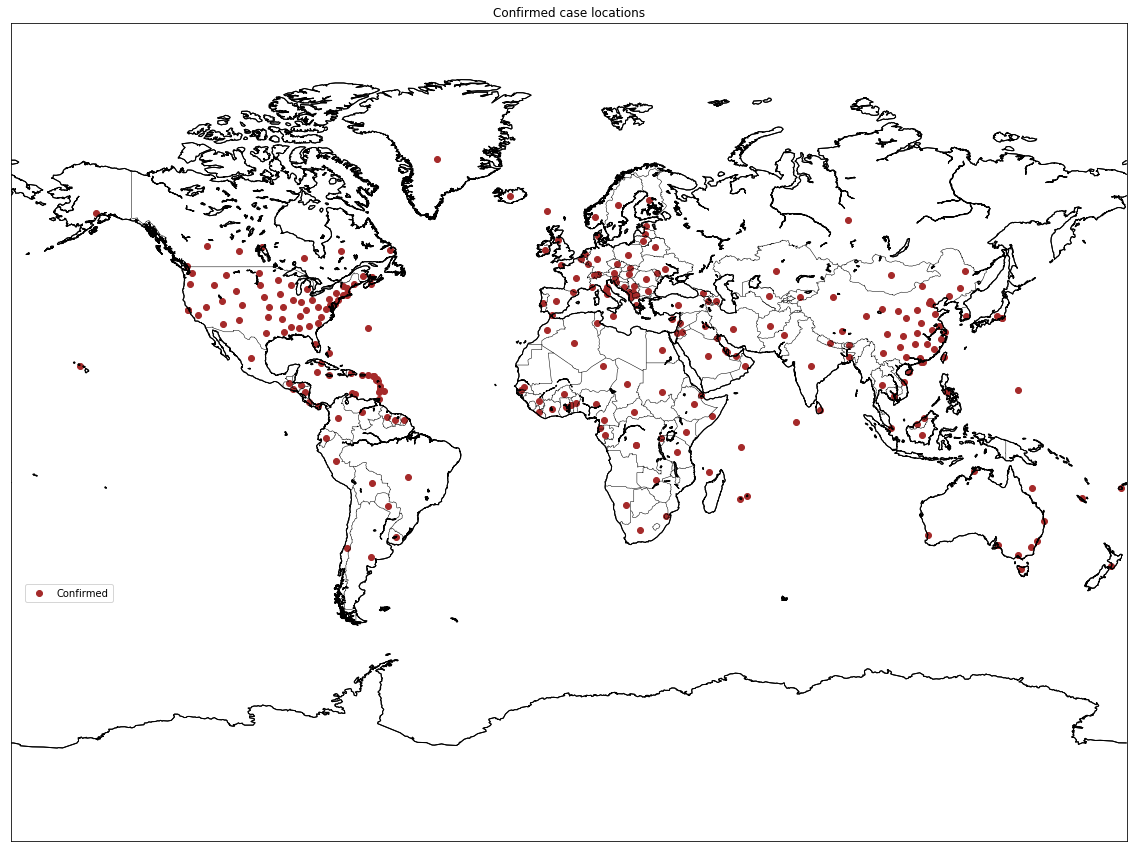

In [17]:
# Put points on the map for the most recent date using the JH lat,Long

map_plotter = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,\
           llcrnrlon=-180, urcrnrlon=180,resolution='l')

plt.figure(figsize=(20, 20))
#m.scatter(lon_list, lat_list, latlon=True)
#m.drawcoastlines()

# only look at the most recent date
most_recent_date = df['Date'].max()
most_recent_date

df_recent = df[df['Date'] == df['Date'].max()]
print('most recent date {} has {} entries'.format(most_recent_date,len(df_recent)))

#map_plotter.shadedrelief()
map_plotter.drawcoastlines()
spot_size=50


D_label_color = {}
# plot one dot for each lat, long in the data
#  -1 second latitude for deaths in that area

confirmed_lat_list = list(df_recent[df_recent['Confirmed']>0]['Lat'])
confirmed_lon_list = list(df_recent[df_recent['Confirmed']>0]['Long'])
map_plotter.scatter(confirmed_lon_list,confirmed_lat_list,latlon=True, color='brown')
D_label_color["Confirmed"] = 'brown'

map_plotter.drawcoastlines()
map_plotter.drawcountries()

ax = plt.gca()    

plt.title("Confirmed case locations")
ax.legend(*get_legend_markers(D_label_color),bbox_to_anchor=(0, 0, .096, .32)) ##bbox_to_anchor=(0, 0, 1.09, 1))

In [18]:
df.to_csv('s2_output_covid-19.csv')